# **PEMTOS Prediction Method**
This multivariate time-seires pipeline enables to produce an out-of-sample prediction without predicting independent variables. You will just have to set dates that you would like to use and predict, and the rest will be taken care of by PEMTOS.

**Steps:**\
Phase 1. Data preprocessing\
Phase 2. In-sample prediction to define golden baseline\
Phase 3. Out-of-sample prediction\
Phase 4. Prediction Outcome\
Phase 5. Feature importance\
Phase 6. Statistical Analysis



# Importing packages (Don't touch, add only)

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
from glob import glob as gg
from functools import reduce

import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.stattools import adfuller
from statsmodels.formula.api import ols

import scipy.stats as sp
from scipy.special import ndtri

import itertools 
from fbprophet import Prophet
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import tree

# company's color palette
colors = ['#0051BA', '#FFDA1A'] 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def dropduplicates_on_Date(dataframe):
  dataframe = dataframe.drop_duplicates(subset='Date', keep='first')

In [4]:
def feature_cleaning(dataframe):
  dataframe["Date"] = pd.to_datetime(dataframe["Date"])
  dataframe = dataframe.drop_duplicates()
  

In [5]:
def past_years_future_valuesues(feature_dataframe):
  for i in feature_futuredays:
    count_a = len(feature_dataframe)
    pastyears = feature_dataframe.iloc[count_a - 2*365: count_a + 1 : 365] # all values from 2 years
    my_date = feature_dataframe.index[-1]
    my_date += dt.timedelta(days = 1)
    feature_dataframe.loc[my_date] = pastyears.median()

In [6]:
def rolling_average_14days_future_values(feature_dataframe):
  # remove unnecessary variables as there could be local-global variable confusion
   for _ in feature_futuredays:
    #  Update the date
      my_date = feature_dataframe.index[-1] 
      my_date += dt.timedelta(days = 1) 
      # Update the date with rolling median
      feature_dataframe.loc[my_date] = feature_dataframe.iloc[:-14,:].median()


In [7]:
def rolling_average_30days_future_values(feature_dataframe):
  # remove unnecessary variables as there could be local-global variable confusion
   for _ in feature_futuredays:
    #  Update the date
      my_date = feature_dataframe.index[-1] 
      my_date += dt.timedelta(days = 1) 
      # Update the date with rolling median
      feature_dataframe.loc[my_date] = feature_dataframe.iloc[:-30,:].median()

      

In [8]:
def mean_of_day_of_the_week_from_past_14days(feature_dataframe):
  # Loop through 35 consecutive days
  for _ in (feature_futuredays):
    pastweeks = feature_dataframe.iloc[-14:] # all values from the past 30 days
    my_date = feature_dataframe.index[-1] # get value of the last index for median
    my_date += dt.timedelta(days = 1) # increase the dates table
    feature_dataframe.loc[my_date] = pastweeks[pastweeks.index.day_name()==my_date.day_name()].median() # Median of the values of that particular day in 30 days  and insert the value at the end 

In [9]:
def mean_of_day_of_the_week_from_past_30days(feature_dataframe):
  # Loop through 35 consecutive days
  for _ in (feature_futuredays):
    pastweeks = feature_dataframe.iloc[-30:] # all values from the past 30 days
    my_date = feature_dataframe.index[-1] # get value of the last index for median
    my_date += dt.timedelta(days = 1) # increase the dates table
    feature_dataframe.loc[my_date] = pastweeks[pastweeks.index.day_name()==my_date.day_name()].median() # Median of the values of that particular day in 30 days  and insert the value at the end 

In [10]:
def variance(data):
  # Number of observations
  n = len(data)
  # Mean of the data
  mean = sum(data) / n
  # Square deviations
  deviations = [(x - mean) ** 2 for x in data]
     # Variance
  variance = sum(deviations) / n
  return variance

In [11]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [12]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

# Pre-Set: Date Range and Prediction Period(*)



When you upload the data files, you can adjust how many days of data you want to use for the prediction. This date selection applies to the entire data set. To do so, change the date range of "start" and "end".

Also, when you can set how many days you want to predict by changing the value of "test_days" and "cv_test_days".

"prophet_cv_initial" has to be within a range of the "new_date_range" - "test_days". To check how many days are in the range, you can use the link below.

Date Range Check: [Link](https://planetcalc.com/274/)

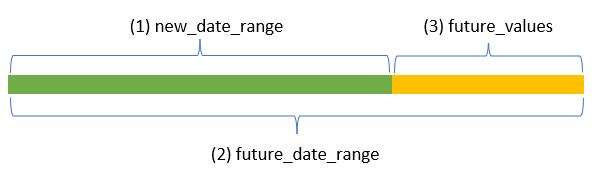


In [ ]:
#General Keys
#(1) set a data range of the testing phase (2) and including tain and test
new_date_range  = pd.date_range(start="2022-01-15", end="2022-06-13", freq="D")

#(2) set a date range of start to end including the future prediction (100% of (1) for train, and predict 35 days ahead)
'''Recommendation: the end date of "new_date_range" + 5 weeks (prediction period) >> Check the calender'''
future_date_range =  pd.date_range(start="2022-01-15", end="2022-07-17", freq="D")

#(3) set a date range of the empty future values without existing data (The future 35 days) >> For graph
future_values = pd.date_range(start = '2022-06-13', end ='2022-07-17', freq = 'D')

In [ ]:
test_days = 35     # Phase 2; 5 weeks testing with existing values
feature_futuredays = range(35)     # Phase 3: 5 weeks in the future

# **Phase 1: Data Preprocessing**

In this section, all uploaded data are cleaned to eliminate outliers or fill milling values. Please review the graphs of each tab to detect any irregular behavior in data.

# Volume of Call

In [ ]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

In [ ]:
vol = pd.DataFrame()


for f in gg('V_*.txt'):
    tmp = pd.read_csv(f,sep=",", skiprows=2)
    vol = pd.concat([vol,tmp],axis=0,ignore_index=True)

vol = vol.drop_duplicates()

In [ ]:
# rename features
volume_n = vol.rename(columns={'Volume (Absolute Act)': 'Volume_Actual', 'Activity Handling Time (Absolute Act)':'AHT', 
                             'Abandons (Absolute Act)':"Abandon_Count",
                             'Volume (Absolute For)': 'Volume_Forecast',
                             'Activity Handling Time (Absolute For)' : "AHT_Forecast",
                             'Abandons (Absolute For)': "Abandon_Forecast"
                             })

volume_feautures = volume_n.loc[:, ['Date', 'AHT', 'Abandon_Count']]
volume_ground = volume_n.loc[:, ['Date', 'Volume_Actual']]
 #Queue Name is included for the future. If we start forecasting other volumes like social. We can still combine them at first, and groupby to seperate.
verint_future = volume_n.loc[:, ['Date',  'AHT_Forecast', 'Abandon_Forecast']]

In [ ]:
# Apply function for fearture organization and cleaning
feature_cleaning(volume_feautures)
feature_cleaning(volume_ground)
feature_cleaning(verint_future)


In [ ]:
# # Set date as index 
volume_ground.set_index('Date', inplace=True)
volume_ground = volume_ground.asfreq("D")
volume_ground.sort_values(by='Date', ascending=True)

# # Set date as index 
volume_feautures.set_index('Date', inplace=True)
volume_feautures = volume_feautures.asfreq("D")
volume_feautures.sort_values(by='Date', ascending=True)

# # Set date as index 
verint_future.set_index('Date', inplace=True)
verint_future = verint_future.asfreq("D")
verint_future.sort_values(by='Date', ascending=True)

# merge the current and future files
volume_feautures=pd.merge(volume_feautures,verint_future, how='inner', left_index=True, right_index=True)

In [ ]:
volume_feautures["AHT"].fillna(volume_feautures["AHT_Forecast"], inplace=True)
volume_feautures["Abandon_Count"].fillna(volume_feautures["Abandon_Forecast"], inplace=True)
volume_feautures = volume_feautures[['AHT', 'Abandon_Count']]
volume_feautures

,AHT,Abandon_Count
Date,,
2019-09-02,830.0,995.0
2019-09-03,824.0,823.0
2019-09-04,824.0,1028.0
2019-09-05,822.0,418.0
2019-09-06,841.0,894.0
...,...,...
2022-07-20,671.0,332.0
2022-07-21,659.0,196.0
2022-07-22,658.0,220.0


In [ ]:
volume_ground.loc[(volume_ground['Volume_Actual'] == 0)]

,Volume_Actual
Date,
2020-05-24,0.0
2020-06-07,0.0
2020-06-14,0.0
2020-06-21,0.0
2020-06-28,0.0
...,...
2020-08-02,0.0
2020-08-09,0.0
2020-08-16,0.0


In [ ]:
volume_feautures['Abandon_Count'].isna().value_counts()

False    1045
True       12
Name: Abandon_Count, dtype: int64

In [ ]:
# fill missing values 
volume_ground = volume_ground.fillna(0)
volume_feautures = volume_feautures.fillna(0)

In [ ]:
# #Set date range
volume_ground1 = volume_ground.reindex(new_date_range)
volume_feautures1 = volume_feautures.reindex(new_date_range) 
# volume_future = volume_future.reindex(new_date_range) 

In [ ]:
volume_ground1

,Volume_Actual
2022-01-15,2661.0
2022-01-16,1484.0
2022-01-17,3269.0
2022-01-18,2851.0
2022-01-19,3288.0
...,...
2022-06-09,2062.0
2022-06-10,2011.0
2022-06-11,1274.0
2022-06-12,686.0


In [ ]:
volume_feautures1

,AHT,Abandon_Count
2022-01-15,596.0,1369.0
2022-01-16,635.0,672.0
2022-01-17,749.0,917.0
2022-01-18,712.0,518.0
2022-01-19,679.0,785.0
...,...,...
2022-06-09,689.0,63.0
2022-06-10,665.0,94.0
2022-06-11,676.0,186.0
2022-06-12,496.0,7.0


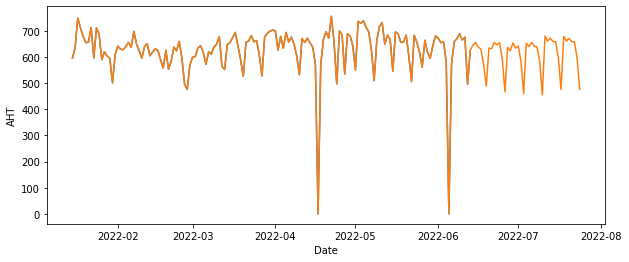

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data = volume_feautures1['AHT']['2021-03-22':], palette = colors)
sns.lineplot(data = volume_feautures['AHT']['2022-01-15':], palette = colors)

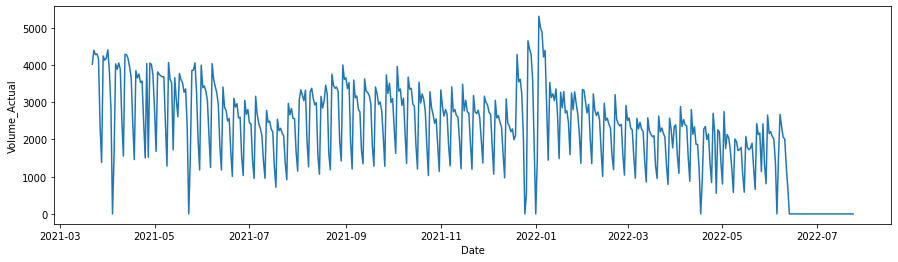

In [ ]:
plt.figure(figsize=(15,4))
sns.lineplot(data = volume_ground['Volume_Actual']['2021-03-22':], palette = colors)

In [ ]:
cv_dfs = [volume_ground]
cv_dfs = pd.concat(cv_dfs, join='outer', axis=1)
cols= cv_dfs.columns

# create empty list for CV
cv_list = []

# same loop but append cv_data to list each time
for column in cv_dfs.columns:
  cv_data = sp.variation(cv_dfs[column], nan_policy = 'omit')#.sort_values(ascending=False)
  cv_data = round(cv_data*100, 2)
  print("{}: {}%".format(column, cv_data))
  cv_list.append(cv_data)


# create new dataframe with column name "value" and data as cv_list
df_vnew = pd.DataFrame(cv_list, columns=['value'])

# set index names and values
df_vnew.index = [cols]
df_vnew.index.name = 'column_name'
# # print new dataframe
# print(df_new)

Volume_Actual: 47.31%


# Google Community Report

In [ ]:
#Load csv files from a folder Google Mobility
df_list = []
for f in sorted(gg('20*_NL_*.csv')):
    df_list.append(pd.read_csv(f, sep=","))
GM_combined = pd.concat(df_list, axis=0, ignore_index=True)
GM_combined = GM_combined.drop_duplicates()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
GM_combined = GM_combined.rename(columns={'date': 'Date'})
feature_cleaning(GM_combined)
GM_combined.sort_values(by='Date', ascending=True)


GM_region_1 = GM_combined.loc[(GM_combined['place_id'] != 'ChIJu-SH28MJxkcRnwq9_851obM')]

In [ ]:
#create DataFrame per sub_region_1 and groupby the date while averaging out values of each columns per day.
#(1)
GM_region_1_list = list(GM_region_1['sub_region_1'].unique())
GM_region_1_dict = dict()

for region in GM_region_1_list:
    GM_region_1_dict[region] = GM_region_1.loc[(GM_region_1['sub_region_1'] == region)]

GM_region_1_dict.keys()

dict_keys(['Drenthe', 'Flevoland', 'Friesland', 'Gelderland', 'Groningen', 'Limburg', 'North Brabant', 'North Holland', 'Overijssel', 'South Holland', 'Utrecht', 'Zeeland'])

In [ ]:
columns = ['retail_and_recreation_percent_change_from_baseline',
           'parks_percent_change_from_baseline'
           ]

#Create new dataframs of each region in sub_region_1
for region_name, region_df in GM_region_1_dict.items():
       #indicate the location of outcome to be saved
       save_path = f"./GM_outputs/{region_name}"

       #create df in metrics of Mean, Median, and Std.
       region_mean = region_df.groupby('Date', as_index=False, sort=True)[columns].mean()
       region_median = region_df.groupby('Date', as_index=False, sort=True)[columns].median()
       region_std = region_df.groupby('Date', as_index=False, sort=True)[columns].std()
       
       #rename the each columns with region name/metric type/column
       rename_dict = {
              'retail_and_recreation_percent_change_from_baseline': f'{region_name}_Metric_Retail_Rec_%Change', 
              'parks_percent_change_from_baseline': f'{region_name}_Metric_Park_%Change',
       }
       region_mean = region_mean.rename(columns=dict(
              map(lambda x: (x[0], x[1].replace('Metric', 'Ave')), rename_dict.items())))
       region_median = region_median.rename(columns=dict(
              map(lambda x: (x[0], x[1].replace('Metric', 'Mid')), rename_dict.items())))
       region_std = region_std.rename(columns=dict(
              map(lambda x: (x[0], x[1].replace('Metric', 'Std')), rename_dict.items())))
       
       save_columns_list = ['Date', 
                            f'{region_name}_Metric_Retail_Rec_%Change', 
                            f'{region_name}_Metric_Park_%Change'
                            ]
 
       region_mean = region_mean[list(map(lambda x: x.replace('Metric', 'Ave'), save_columns_list))].copy()
       region_median = region_median[list(map(lambda x: x.replace('Metric', 'Mid'), save_columns_list))].copy()
       region_std = region_std[list(map(lambda x: x.replace('Metric', 'Std'), save_columns_list))].copy()

       #each file is saved in the path and ready to merge with Volume
       os.makedirs(save_path, exist_ok=True)
       region_mean.to_csv(f"{save_path}/{region_name}_GM_mean.csv", index = False)
       region_median.to_csv(f"{save_path}/{region_name}_GM_median.csv", index = False)
       region_std.to_csv(f"{save_path}/{region_name}_GM_std.csv", index = False)

In [ ]:
mobility = pd.DataFrame()

for f in gg('/content/GM_outputs/*/*.csv'):
    tmp = pd.read_csv(f)
    mobility = pd.concat([mobility,tmp],axis=1,ignore_index=False)

In [ ]:
mobility = mobility.loc[:,~mobility.columns.duplicated()]
mobility["Date"] = pd.to_datetime(mobility["Date"])

In [ ]:
#indexed the date column
mobility.set_index('Date', inplace=True)
mobility = mobility.asfreq("D")


# fill null values
mobility.fillna(method = 'ffill', inplace = True)

In [ ]:
#select the date range
mobility1 = mobility.reindex(new_date_range)

# fill null values
mobility1.fillna(method = 'ffill', inplace = True)

In [ ]:
#select the date range
mobility1 = mobility1.reindex(new_date_range)

In [ ]:
mobility1

,Zeeland_Mid_Retail_Rec_%Change,Zeeland_Mid_Park_%Change,Zeeland_Std_Retail_Rec_%Change,Zeeland_Std_Park_%Change,Zeeland_Ave_Retail_Rec_%Change,...,Overijssel_Std_Park_%Change,Overijssel_Mid_Retail_Rec_%Change,Overijssel_Mid_Park_%Change,Overijssel_Ave_Retail_Rec_%Change,Overijssel_Ave_Park_%Change
2022-01-15,-27.0,-12.0,8.348320,20.868066,-29.777778,...,9.988327,-21.0,19.0,-19.100000,19.833333
2022-01-16,-40.0,-23.0,22.086410,13.894843,-38.857143,...,14.836610,-33.0,24.5,-30.545455,20.125000
2022-01-17,-8.0,4.5,8.185353,15.484401,-7.000000,...,4.358899,-16.0,26.0,-13.923077,24.000000
2022-01-18,-14.0,16.0,6.760178,18.096961,-12.200000,...,11.618950,-15.0,18.0,-12.142857,14.500000
2022-01-19,-23.0,-7.5,7.026142,16.797817,-22.166667,...,9.322911,-21.0,20.5,-18.857143,16.750000
...,...,...,...,...,...,...,...,...,...,...,...
2022-06-09,23.5,226.0,33.844744,137.292874,28.666667,...,42.426407,7.0,64.0,8.588235,64.000000
2022-06-10,5.0,262.0,27.242299,140.603461,15.142857,...,90.509668,1.0,96.0,4.375000,96.000000
2022-06-11,10.0,276.5,25.268558,127.066912,16.250000,...,45.961941,1.5,160.5,4.400000,160.500000
2022-06-12,30.0,242.5,16.504545,16.660832,30.000000,...,40.550380,9.0,109.0,18.900000,106.666667


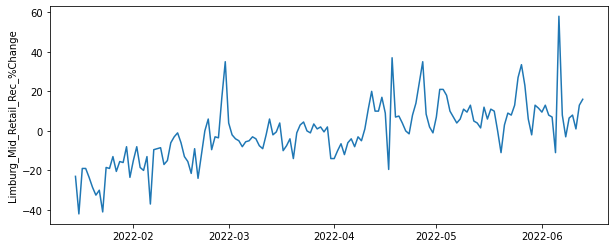

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data = mobility1['Limburg_Mid_Retail_Rec_%Change'], palette = colors)

# Weather

In [ ]:
#Load csv files from a folder Google Mobility
df_list = []
for f in sorted(gg('result*.txt')):
    df_list.append(pd.read_csv(f, skiprows=95))
weather = pd.concat(df_list, axis=0, ignore_index=True)
weather = weather.drop_duplicates()

In [ ]:
#Change the datatypes
#datetime object
weather.columns = weather.columns.str.strip()
weather = weather.rename(columns={'YYYYMMDD': 'Date'})
weather["Date"] = pd.to_datetime(weather["Date"], format = "%Y%m%d")
weather.sort_values(by='Date', ascending=True)
weather = weather.drop_duplicates()

#integer to object
weather["# STN"] = weather["# STN"].astype(str)

weather = weather[['# STN', 'Date', 'DDVEC', 'FHVEC', 'FG', 'FXX',  'TG', 'TN', 'TX', 'SQ', 'NG', 'RH']].copy()

#select the data types
columns = ['DDVEC', 'FHVEC', 'FG', 'FXX',  'TG', 'TN', 'TX', 'SQ', 'NG', 'RH']

#change the data types from object to float in the selected columns
weather[columns] = weather[columns].apply(pd.to_numeric, errors = 'coerce', axis = 1)
weather["RH"] = weather['RH'].apply(lambda x:0.05 if x == 0.1 else x)

In [ ]:
# Remove useless stations with entirely null values
weather = weather.loc[(weather['# STN'] != '308')]
weather = weather.loc[(weather['# STN'] != '313')]
weather = weather.loc[(weather['# STN'] != '331')]

In [ ]:
#group by per day
#take median of each station
weather = weather.groupby('Date', as_index=True, sort=True)[columns].median()

In [ ]:
weather.fillna(method = 'ffill', inplace = True)

In [ ]:
# Set the date range
weather1 = weather.reindex(new_date_range)

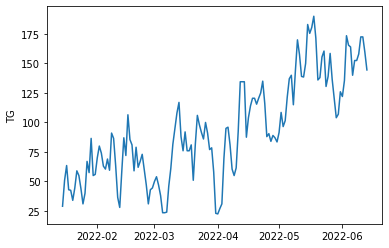

In [ ]:
sns.lineplot(data = weather1['TG'], palette = 'g')
# sns.lineplot(data = weather['DDVEC'], palette = 'o')
# sns.lineplot(data = weather['SQ'], palette = 'b')
# sns.lineplot(data = weather['RH'], palette = 'r')


# Holiday

In [ ]:
holi = pd.read_excel('/content/Holidays.xlsx')
holi = holi.drop_duplicates()

In [ ]:
feature_cleaning(holi)

In [ ]:
#fill non sales dates with zero
holi = holi.fillna(0)
holi.isnull().sum()

#Set the Sales_Offered as binary
holi['Holidays'] = holi['Holidays'].astype('bool')
holi['christmas_NY'] = holi['christmas_NY'].astype('bool')
holi['easter_whit'] = holi['easter_whit'].astype('bool')

#One Hot Encoding on the day of the week
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(holi[['Day_of_Week']]).toarray())
holi = holi.join(encoder_df)

#indexed the date column
holi.set_index('Date', inplace=True)
holi = holi.asfreq("D")

In [ ]:
holi = holi.rename(columns={0: 'Fri',
                                    1: 'Mon',
                                    2: 'Sat',
                                    3: 'Sun',
                                    4: 'Thu',
                                    5: 'Tue',
                                    6: 'Wed'                             
})

In [ ]:
holi = holi[['Holidays', 'christmas_NY', 'easter_whit', 
      'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', ]]

In [ ]:
#Set date range
holi1 = holi.reindex(new_date_range)
holi1

,Holidays,christmas_NY,easter_whit,Mon,Tue,Wed,Thu,Fri,Sat,Sun
2022-01-15,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-01-16,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2022-01-17,False,False,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-01-18,False,False,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2022-01-19,False,False,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2022-06-09,False,False,False,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2022-06-10,False,False,False,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2022-06-11,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2022-06-12,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,1.0


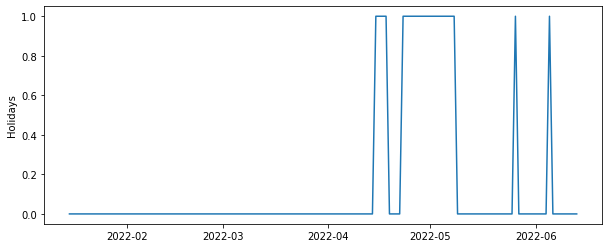

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data = holi1['Holidays'], palette = colors)

# Covid Stringency Index

In [ ]:
#Load csv files from a folder
df_list = []
for f in sorted(gg('/content/owid-covid*.csv')):
    df_list.append(pd.read_csv(f, sep=","))
stringency = pd.concat(df_list, axis=0, ignore_index=True)
stringency = stringency.drop_duplicates()

In [ ]:
stringency

,iso_code,continent,location,date,total_cases,...,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,...,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,...,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,...,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,...,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,...,0.511,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
197689,ZWE,Africa,Zimbabwe,2022-06-25,255309.0,...,0.571,NaN,NaN,NaN,NaN
197690,ZWE,Africa,Zimbabwe,2022-06-26,255355.0,...,0.571,NaN,NaN,NaN,NaN
197691,ZWE,Africa,Zimbabwe,2022-06-27,255383.0,...,0.571,NaN,NaN,NaN,NaN
197692,ZWE,Africa,Zimbabwe,2022-06-28,255383.0,...,0.571,NaN,NaN,NaN,NaN


In [ ]:
# select Netherlands data, select necessary columns and change data types
stringency = stringency.rename(columns={'date': 'Date'})
NL_Stringency = stringency.loc[(stringency['location'] == 'Netherlands')]
NL_Stringency = NL_Stringency[['Date', 'stringency_index', 'new_cases_smoothed',
                               'new_deaths_smoothed',
                               ]]

NL_Stringency["Date"] = pd.to_datetime(NL_Stringency["Date"])
NL_Stringency.sort_values(by='Date', ascending=True)
NL_Stringency = NL_Stringency.drop_duplicates()
NL_Stringency.fillna(method = 'ffill', inplace = True)

# set date index
NL_Stringency.set_index('Date', inplace=True)
NL_Stringency = NL_Stringency.asfreq("D")

#Set date range
NL_Stringency1 = NL_Stringency.reindex(new_date_range)

In [ ]:
NL_Stringency.columns

Index(['stringency_index', 'new_cases_smoothed', 'new_deaths_smoothed'], dtype='object')

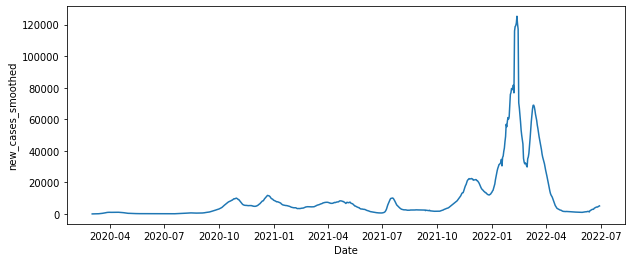

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data = NL_Stringency['new_cases_smoothed'], palette = colors)

In [ ]:
NL_Stringency1

,stringency_index,new_cases_smoothed,new_deaths_smoothed
2022-01-15,58.33,32567.286,10.714
2022-01-16,58.33,34593.143,10.714
2022-01-17,58.33,30444.714,10.000
2022-01-18,58.33,35794.857,7.429
2022-01-19,58.33,36681.000,9.143
...,...,...,...
2022-06-09,19.44,1546.143,0.714
2022-06-10,19.44,1656.857,1.000
2022-06-11,19.44,1451.286,0.857
2022-06-12,19.44,1274.286,0.857


# Lockdown Dates

In [ ]:
lockdown = pd.read_excel('/content/Lockdown_dates.xlsx')
lockdown = lockdown.drop_duplicates()
lockdown["Date"] = pd.to_datetime(lockdown["Date"])
lockdown = lockdown.fillna(0)

feature_cleaning(lockdown)

# set date index
lockdown.set_index('Date', inplace=True)
lockdown = lockdown.asfreq("D")

#Set date range
lockdown1 = lockdown.reindex(new_date_range)


In [ ]:
lockdown1

,Lockdown
2022-01-15,0.0
2022-01-16,0.0
2022-01-17,0.0
2022-01-18,0.0
2022-01-19,0.0
...,...
2022-06-09,0.0
2022-06-10,0.0
2022-06-11,0.0
2022-06-12,0.0


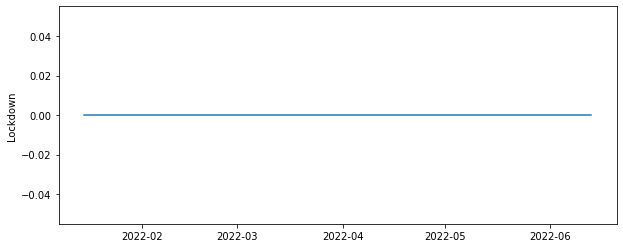

In [ ]:
plt.figure(figsize=(10,4))
sns.lineplot(data = lockdown1['Lockdown'], palette = colors)

# In-Sample Dataset

In this section, all dataframes are going to be merged.

In [ ]:
from functools import reduce
import pandas as pd

dfs = [volume_ground1, volume_feautures1, social1, Abandoned1, mobility1, weather1, holi1,
       NL_Stringency1, lockdown1, market_sales1, repeated1, salesforecast1
       ] # do not include CCI as it is difficult to forecast the value
# nan_value = 0

# solution 1 (fast)
all = pd.concat(dfs, join='outer', axis=1)

In [ ]:
all.columns.nunique()

113

In [ ]:
all.fillna(method = 'ffill', inplace = True)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

# Out-of-Sample Dataset

---
**Coefficient of Variation (CV)**\
It is a ratio of the standard deviation to the mean. In other words, it evaluates how much variance the dataset has shown in percentage. The higher the value, the higher the variance.
The calculation is Standard Deviation/ Mean. If CV > 1, it indicates a relatively high variation of data, while CV < 1 means less variance. This statistical analysis is benefitial to evaluate which features can be useful to include in the out-of-sample forecasting. It is because even if all features improved the accuracy in in-sample, it doesn't mean it is helpful also for the out-of-sample. Standard Deviation is a common measure of variability, and it is simply the square roof of the variance. However, since it uses the same unit as the original data, it is difficult to use for the feature evaluation since they have different units.







```
CV = 100*Std/Mean
```
---


In [ ]:
cv_dfs = [social, mobility, NL_Stringency, Abandoned, repeated, weather]
cv_dfs = pd.concat(cv_dfs, join='outer', axis=1)

In [ ]:
cv_dfs.head()

,FB_Likes,FB_Visits,Insta_Likes,Insta_Visits,Zeeland_Mid_Retail_Rec_%Change,Zeeland_Mid_Park_%Change,Zeeland_Std_Retail_Rec_%Change,Zeeland_Std_Park_%Change,Zeeland_Ave_Retail_Rec_%Change,Zeeland_Ave_Park_%Change,Drenthe_Ave_Retail_Rec_%Change,Drenthe_Ave_Park_%Change,Drenthe_Std_Retail_Rec_%Change,Drenthe_Std_Park_%Change,Drenthe_Mid_Retail_Rec_%Change,Drenthe_Mid_Park_%Change,North Holland_Mid_Retail_Rec_%Change,North Holland_Mid_Park_%Change,North Holland_Ave_Retail_Rec_%Change,North Holland_Ave_Park_%Change,North Holland_Std_Retail_Rec_%Change,North Holland_Std_Park_%Change,Groningen_Mid_Retail_Rec_%Change,Groningen_Mid_Park_%Change,Groningen_Ave_Retail_Rec_%Change,Groningen_Ave_Park_%Change,Groningen_Std_Retail_Rec_%Change,Groningen_Std_Park_%Change,South Holland_Ave_Retail_Rec_%Change,South Holland_Ave_Park_%Change,South Holland_Mid_Retail_Rec_%Change,South Holland_Mid_Park_%Change,South Holland_Std_Retail_Rec_%Change,South Holland_Std_Park_%Change,Gelderland_Mid_Retail_Rec_%Change,Gelderland_Mid_Park_%Change,Gelderland_Std_Retail_Rec_%Change,Gelderland_Std_Park_%Change,Gelderland_Ave_Retail_Rec_%Change,Gelderland_Ave_Park_%Change,Utrecht_Std_Retail_Rec_%Change,Utrecht_Std_Park_%Change,Utrecht_Mid_Retail_Rec_%Change,Utrecht_Mid_Park_%Change,Utrecht_Ave_Retail_Rec_%Change,Utrecht_Ave_Park_%Change,Limburg_Ave_Retail_Rec_%Change,Limburg_Ave_Park_%Change,Limburg_Mid_Retail_Rec_%Change,Limburg_Mid_Park_%Change,Limburg_Std_Retail_Rec_%Change,Limburg_Std_Park_%Change,Friesland_Std_Retail_Rec_%Change,Friesland_Std_Park_%Change,Friesland_Mid_Retail_Rec_%Change,Friesland_Mid_Park_%Change,Friesland_Ave_Retail_Rec_%Change,Friesland_Ave_Park_%Change,Flevoland_Std_Retail_Rec_%Change,Flevoland_Std_Park_%Change,Flevoland_Mid_Retail_Rec_%Change,Flevoland_Mid_Park_%Change,Flevoland_Ave_Retail_Rec_%Change,Flevoland_Ave_Park_%Change,North Brabant_Ave_Retail_Rec_%Change,North Brabant_Ave_Park_%Change,North Brabant_Mid_Retail_Rec_%Change,North Brabant_Mid_Park_%Change,North Brabant_Std_Retail_Rec_%Change,North Brabant_Std_Park_%Change,Overijssel_Std_Retail_Rec_%Change,Overijssel_Std_Park_%Change,Overijssel_Mid_Retail_Rec_%Change,Overijssel_Mid_Park_%Change,Overijssel_Ave_Retail_Rec_%Change,Overijssel_Ave_Park_%Change,stringency_index,new_cases_smoothed,new_deaths_smoothed,Abandoned_ratio,# RC (Same day),Sum of Accepted,% RC,DDVEC,FHVEC,FG,FXX,TG,TN,TX,SQ,NG,RH
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-09-02,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250.0,36.0,42.0,100.0,153.5,94.0,201.5,93.5,5.0,0.0
2019-09-03,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,238.0,43.0,47.0,110.0,166.5,132.0,201.5,16.0,7.0,0.0
2019-09-04,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,217.0,49.0,52.0,140.0,154.5,117.5,189.0,25.5,6.0,55.0
2019-09-05,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
cols= cv_dfs.columns

In [ ]:
# create empty list for CV
cv_list = []

# same loop but append cv_data to list each time
for column in cv_dfs.columns:
  cv_data = sp.variation(cv_dfs[column], nan_policy = 'omit')#.sort_values(ascending=False)
  cv_data = round(cv_data*100, 2)
  print("{}: {}%".format(column, cv_data))
  cv_list.append(cv_data)


# create new dataframe with column name "value" and data as cv_list
df_new = pd.DataFrame(cv_list, columns=['value'])

# set index names and values
df_new.index = [cols]
df_new.index.name = 'column_name'
# # print new dataframe
# print(df_new)

FB_Likes: 80.74%
FB_Visits: 81.49%
Insta_Likes: 144.71%
Insta_Visits: 65.05%
Zeeland_Mid_Retail_Rec_%Change: -9472.43%
Zeeland_Mid_Park_%Change: 113.21%
Zeeland_Std_Retail_Rec_%Change: 70.83%
Zeeland_Std_Park_%Change: 101.78%
Zeeland_Ave_Retail_Rec_%Change: 7817.12%
Zeeland_Ave_Park_%Change: 119.07%
Drenthe_Ave_Retail_Rec_%Change: -248.98%
Drenthe_Ave_Park_%Change: 117.85%
Drenthe_Std_Retail_Rec_%Change: 56.61%
Drenthe_Std_Park_%Change: 72.51%
Drenthe_Mid_Retail_Rec_%Change: -218.56%
Drenthe_Mid_Park_%Change: 118.03%
North Holland_Mid_Retail_Rec_%Change: -111.42%
North Holland_Mid_Park_%Change: 142.07%
North Holland_Ave_Retail_Rec_%Change: -130.28%
North Holland_Ave_Park_%Change: 154.42%
North Holland_Std_Retail_Rec_%Change: 30.84%
North Holland_Std_Park_%Change: 39.12%
Groningen_Mid_Retail_Rec_%Change: -135.65%
Groningen_Mid_Park_%Change: 99.86%
Groningen_Ave_Retail_Rec_%Change: -158.82%
Groningen_Ave_Park_%Change: 100.08%
Groningen_Std_Retail_Rec_%Change: 47.58%
Groningen_Std_Park_%C

In [ ]:
df_new = df_new.reset_index()
good_cvs = df_new.loc[(df_new['value'] <80 ) & (df_new['value'] > 0)]

In [ ]:
feature_list = good_cvs['level_0'].values.tolist()
feature_list

['Insta_Visits',
 'Zeeland_Std_Retail_Rec_%Change',
 'Drenthe_Std_Retail_Rec_%Change',
 'Drenthe_Std_Park_%Change',
 'North Holland_Std_Retail_Rec_%Change',
 'North Holland_Std_Park_%Change',
 'Groningen_Std_Retail_Rec_%Change',
 'South Holland_Std_Retail_Rec_%Change',
 'South Holland_Std_Park_%Change',
 'Gelderland_Std_Retail_Rec_%Change',
 'Gelderland_Std_Park_%Change',
 'Utrecht_Std_Retail_Rec_%Change',
 'Utrecht_Std_Park_%Change',
 'Limburg_Std_Retail_Rec_%Change',
 'Limburg_Std_Park_%Change',
 'Friesland_Std_Retail_Rec_%Change',
 'North Brabant_Std_Retail_Rec_%Change',
 'North Brabant_Std_Park_%Change',
 'Overijssel_Std_Retail_Rec_%Change',
 'stringency_index',
 'Abandoned_ratio',
 '# RC (Same day)',
 'Sum of Accepted',
 '% RC',
 'DDVEC',
 'FHVEC',
 'FG',
 'FXX',
 'TG',
 'TN',
 'TX',
 'NG']

Erase any data in future range

In [ ]:
'''Movig Average of the same day of the week from the past 30 days'''
# Covid-19 Stringency Index
mean_of_day_of_the_week_from_past_30days(NL_Stringency)
NL_Stringency2 = NL_Stringency

# social media
mean_of_day_of_the_week_from_past_30days(social)
social2 = social

# Google Community Mobility Report
mean_of_day_of_the_week_from_past_30days(mobility)
mobility2 = mobility

# Abandoned
mean_of_day_of_the_week_from_past_30days(Abandoned)
Abandoned2 = Abandoned

# Repeated Calls
mean_of_day_of_the_week_from_past_30days(repeated)
repeated2 = repeated

''' Taking Mean Value of Past 2 Years '''
past_years_future_valuesues(weather)
weather2 = weather.reindex(future_date_range)

        
''' No Need to Add Future Values '''
salesforecast2 = salesforecast.reindex(future_date_range)
holi2 = holi.reindex(future_date_range)
lockdown2 = lockdown.reindex(future_date_range)
volume_feautures2 = volume_feautures.reindex(future_date_range)
market_sales2 = market_sales.reindex(future_date_range)

# volume_ground

In [ ]:
# Calculate Variance of Each Feature
# as you can see, the vanriance value is not measured by the same unit, 
# so it is difficult to determine which features have more variance than other.
print(social2.var())
print(volume_feautures2.var())

FB_Likes        1.508855e+03
FB_Visits       1.062731e+06
Insta_Likes     2.459776e+03
Insta_Visits    8.509818e+05
dtype: float64
AHT               7776.885454
Abandon_Count    56194.601063
dtype: float64


In [ ]:
volume_feautures2.loc[(volume_feautures2['AHT'] != 0)].count()

AHT              182
Abandon_Count    182
dtype: int64

Mergining all dataset for the future values

In [ ]:
future_clean = [            
              # features with less variance
              volume_feautures2, holi2,
               lockdown2, market_sales2,salesforecast2,
              

       ] # do not include CCI as it is difficult to forecast the value
# nan_value = 0

# solution 1 (fast)
future_clean = pd.concat(future_clean, join='outer', axis=1)
future_clean = future_clean.reindex(future_date_range)
future_clean.columns.to_list()

['AHT',
 'Abandon_Count',
 'Holidays',
 'christmas_NY',
 'easter_whit',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 'Lockdown',
 'SumofSales_O',
 'SumofSales_R',
 'SumofSales_S',
 'Non_Store_Forecast',
 'Store_Forecast',
 'Total_Forecast']

In [ ]:
dfs_clean = [            
              # features with less variance
              volume_feautures2, weather2, holi2,
              NL_Stringency2, lockdown2, market_sales2, repeated2, salesforecast2,
              
              # features with more variance
              Abandoned2, mobility2, social2 

       ] # do not include CCI as it is difficult to forecast the value
# nan_value = 0

# solution 1 (fast)
dfs_clean = pd.concat(dfs_clean, join='outer', axis=1)
dfs_clean = dfs_clean.reindex(future_date_range)

In [ ]:
dfs_clean.fillna(method = 'ffill', inplace = True)

In [ ]:
dfs_future = [volume_ground1, dfs_clean

       ] # do not include CCI as it is difficult to forecast the value
# nan_value = 0

# solution 1 (fast)
all_future = pd.concat(dfs_future, join='outer', axis=1)
all_future = all_future.reindex(future_date_range)

In [ ]:
all_future = all_future.reindex(future_date_range)

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
all_future

,Volume_Actual,AHT,Abandon_Count,DDVEC,FHVEC,FG,FXX,TG,TN,TX,SQ,NG,RH,Holidays,christmas_NY,easter_whit,Mon,Tue,Wed,Thu,Fri,Sat,Sun,stringency_index,new_cases_smoothed,new_deaths_smoothed,Lockdown,SumofSales_O,SumofSales_R,SumofSales_S,# RC (Same day),Sum of Accepted,% RC,Non_Store_Forecast,Store_Forecast,Total_Forecast,Abandoned_ratio,Zeeland_Mid_Retail_Rec_%Change,Zeeland_Mid_Park_%Change,Zeeland_Std_Retail_Rec_%Change,Zeeland_Std_Park_%Change,Zeeland_Ave_Retail_Rec_%Change,Zeeland_Ave_Park_%Change,Drenthe_Ave_Retail_Rec_%Change,Drenthe_Ave_Park_%Change,Drenthe_Std_Retail_Rec_%Change,Drenthe_Std_Park_%Change,Drenthe_Mid_Retail_Rec_%Change,Drenthe_Mid_Park_%Change,North Holland_Mid_Retail_Rec_%Change,North Holland_Mid_Park_%Change,North Holland_Ave_Retail_Rec_%Change,North Holland_Ave_Park_%Change,North Holland_Std_Retail_Rec_%Change,North Holland_Std_Park_%Change,Groningen_Mid_Retail_Rec_%Change,Groningen_Mid_Park_%Change,Groningen_Ave_Retail_Rec_%Change,Groningen_Ave_Park_%Change,Groningen_Std_Retail_Rec_%Change,Groningen_Std_Park_%Change,South Holland_Ave_Retail_Rec_%Change,South Holland_Ave_Park_%Change,South Holland_Mid_Retail_Rec_%Change,South Holland_Mid_Park_%Change,South Holland_Std_Retail_Rec_%Change,South Holland_Std_Park_%Change,Gelderland_Mid_Retail_Rec_%Change,Gelderland_Mid_Park_%Change,Gelderland_Std_Retail_Rec_%Change,Gelderland_Std_Park_%Change,Gelderland_Ave_Retail_Rec_%Change,Gelderland_Ave_Park_%Change,Utrecht_Std_Retail_Rec_%Change,Utrecht_Std_Park_%Change,Utrecht_Mid_Retail_Rec_%Change,Utrecht_Mid_Park_%Change,Utrecht_Ave_Retail_Rec_%Change,Utrecht_Ave_Park_%Change,Limburg_Ave_Retail_Rec_%Change,Limburg_Ave_Park_%Change,Limburg_Mid_Retail_Rec_%Change,Limburg_Mid_Park_%Change,Limburg_Std_Retail_Rec_%Change,Limburg_Std_Park_%Change,Friesland_Std_Retail_Rec_%Change,Friesland_Std_Park_%Change,Friesland_Mid_Retail_Rec_%Change,Friesland_Mid_Park_%Change,Friesland_Ave_Retail_Rec_%Change,Friesland_Ave_Park_%Change,Flevoland_Std_Retail_Rec_%Change,Flevoland_Std_Park_%Change,Flevoland_Mid_Retail_Rec_%Change,Flevoland_Mid_Park_%Change,Flevoland_Ave_Retail_Rec_%Change,Flevoland_Ave_Park_%Change,North Brabant_Ave_Retail_Rec_%Change,North Brabant_Ave_Park_%Change,North Brabant_Mid_Retail_Rec_%Change,North Brabant_Mid_Park_%Change,North Brabant_Std_Retail_Rec_%Change,North Brabant_Std_Park_%Change,Overijssel_Std_Retail_Rec_%Change,Overijssel_Std_Park_%Change,Overijssel_Mid_Retail_Rec_%Change,Overijssel_Mid_Park_%Change,Overijssel_Ave_Retail_Rec_%Change,Overijssel_Ave_Park_%Change,FB_Likes,FB_Visits,Insta_Likes,Insta_Visits
2022-01-15,2661.0,596.0,1369.0,156.0,29.5,34.0,70.0,29.00,11.0,46.50,0.00,8.00,0.00,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,58.33,32567.286000,10.714000,0.0,1.225004e+07,1.903254e+06,3.133212e+06,420.0000,1324.0000,0.317221,8860000.0,18700000.0,27560000.0,0.510432,-27.0000,-12.0000,8.348320,20.868066,-29.777778,-11.857143,-21.500000,-2.142857,6.553201,11.495341,-21.0000,0.0000,-25.0000,-25.0000,-25.909091,-21.800000,16.828851,28.777968,-15.5000,23.0000,-14.625000,23.0000,13.710658,1.414214,-21.733333,-3.809524,-21.0000,-2.0000,11.846365,22.870547,-22.0000,0.000,10.499206,23.853721,-20.650000,-7.000000,10.984621,25.143588,-23.0000,-24.0000,-25.523810,-26.200000,-24.736842,-15.416667,-23.0000,-17.500,12.822905,29.974105,8.207074,28.500000,-24.0000,16.5000,-23.583333,18.250000,14.346063,23.039304,-25.0000,-19.0000,-18.857143,-17.142857,-23.866667,-13.400000,-24.000,-8.0000,13.320524,22.525541,11.068685,9.988327,-21.0000,19.0000,-19.100000,19.833333,44.00000,1899.000,149.00000,2268.00000
2022-01-16,1484.0,635.0,672.0,247.0,44.0,47.0,100.0,51.00,13.0,71.00,0.00,8.00,2.00,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0,1.0,58.33,34593.143000,10.714000,0.0,1.225004e+07,1.903254e+06,3.133212e+06,239.0000,815.0000,0.293252,8860000.0,18700000.0,27560000.0,0.454240,-40.0000,-23.0000,22.086410,13.894843,-38.857143,-21.666667,-29.250000,4.625000,6.551081,13.222681,-29.5000,11.0000,-28.0000,-3.0000,-26.105263,-7.

In [ ]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

In [ ]:
all_future.columns.to_list()

['Volume_Actual',
 'AHT',
 'Abandon_Count',
 'DDVEC',
 'FHVEC',
 'FG',
 'FXX',
 'TG',
 'TN',
 'TX',
 'SQ',
 'NG',
 'RH',
 'Holidays',
 'christmas_NY',
 'easter_whit',
 'Mon',
 'Tue',
 'Wed',
 'Thu',
 'Fri',
 'Sat',
 'Sun',
 'stringency_index',
 'new_cases_smoothed',
 'new_deaths_smoothed',
 'Lockdown',
 'SumofSales_O',
 'SumofSales_R',
 'SumofSales_S',
 '# RC (Same day)',
 'Sum of Accepted',
 '% RC',
 'Non_Store_Forecast',
 'Store_Forecast',
 'Total_Forecast',
 'Abandoned_ratio',
 'Zeeland_Mid_Retail_Rec_%Change',
 'Zeeland_Mid_Park_%Change',
 'Zeeland_Std_Retail_Rec_%Change',
 'Zeeland_Std_Park_%Change',
 'Zeeland_Ave_Retail_Rec_%Change',
 'Zeeland_Ave_Park_%Change',
 'Drenthe_Ave_Retail_Rec_%Change',
 'Drenthe_Ave_Park_%Change',
 'Drenthe_Std_Retail_Rec_%Change',
 'Drenthe_Std_Park_%Change',
 'Drenthe_Mid_Retail_Rec_%Change',
 'Drenthe_Mid_Park_%Change',
 'North Holland_Mid_Retail_Rec_%Change',
 'North Holland_Mid_Park_%Change',
 'North Holland_Ave_Retail_Rec_%Change',
 'North Hollan

In [ ]:
# 'Volume_Actual', 'AHT', 'Abandon_Count', 'Volume_Forecast', 'AHT_Forecast', 'Abandon_Forecast', 'DDVEC', 'FHVEC',
#  'FG', 'FXX', 'TG', 'TN', 'TX', 'SQ', 'NG', 'RH',
#  'Holidays', 'christmas_NY', 'easter_whit',
#  'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun',
#  'stringency_index', 'new_cases_smoothed', 'new_deaths_smoothed', 'new_vaccinations_smoothed', 'people_fully_vaccinated',
#  'new_people_vaccinated_smoothed',
#  'Lockdown',
#  'SumofSales_O', 'SumofSales_S', 'SumofSales_R', 'SumofSales_FO', 'SumofSales_FS', 'SumofSales_FR',
#  '# RC (Same day)', 'Sum of Accepted', '% RC',
#  'Non_Store_Forecast', 'Store_Forecast', 'Total_Forecast', 'Abandoned_ratio',
#  'Gelderland_Mid_Retail_Rec_%Change', 'Gelderland_Mid_Park_%Change',
#  'Gelderland_Std_Retail_Rec_%Change', 'Gelderland_Std_Park_%Change',
#  'Gelderland_Ave_Retail_Rec_%Change', 'Gelderland_Ave_Park_%Change', 
#  'FB_Likes', 'FB_Visits', 'Insta_Likes', 'Insta_Visits'

In [ ]:
all_future_graph = all_future.reindex(future_values)

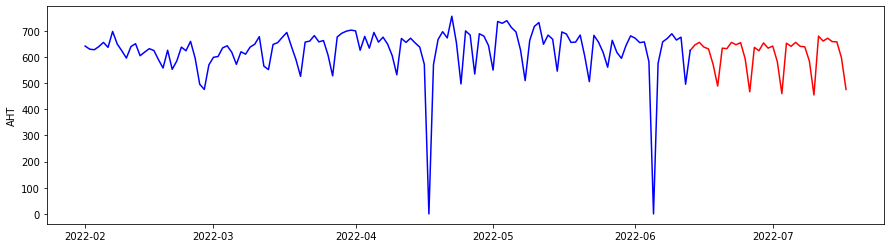

In [ ]:
plt.figure(figsize=(15,4))
sns.lineplot(data = all_future_graph['AHT']['2022-02-01':], color = 'r')
sns.lineplot(data = all['AHT']['2022-02-01':], color = 'b')

#Residual Check

AHT Residuals

In [ ]:
volume_n['diff'] = volume_n['AHT'] - volume_n['AHT_Forecast']
volume_n.loc[(volume_n['diff'] > 1500)]

,Queue Name,Date,Time,Time Interval,Volume_Actual,...,Service Level (Absolute Req),Abandon_Count,Abandon_Forecast,Net Staffing (Absolute For),diff
727,Combined - Phone,02/02/2021,12:00 AM,24:00,3620.0,...,80,542.0,1015,-337.0,1674.0


In [ ]:
volume_n.iat[342,7] = 500

In [ ]:
volume_n

,Queue Name,Date,Time,Time Interval,Volume_Actual,...,Service Level (Absolute Req),Abandon_Count,Abandon_Forecast,Net Staffing (Absolute For),diff
0,Combined - Phone,03/14/2022,12:00 AM,24:00,2581.0,...,80,158.0,428,-142.0,-53.0
1,Combined - Phone,03/15/2022,12:00 AM,24:00,2234.0,...,80,161.0,310,-147.0,-52.0
2,Combined - Phone,03/16/2022,12:00 AM,24:00,2138.0,...,80,171.0,409,-141.0,-32.0
3,Combined - Phone,03/17/2022,12:00 AM,24:00,2075.0,...,80,115.0,102,-19.0,-9.0
4,Combined - Phone,03/18/2022,12:00 AM,24:00,2099.0,...,80,190.0,468,-172.0,-59.0
...,...,...,...,...,...,...,...,...,...,...,...
1040,Combined - Phone,08/11/2021,12:00 AM,24:00,3106.0,...,80,659.0,734,-298.0,45.0
1041,Combined - Phone,08/12/2021,12:00 AM,24:00,2928.0,...,80,621.0,632,-286.0,95.0
1042,Combined - Phone,08/13/2021,12:00 AM,24:00,2987.0,...,80,596.0,804,-291.0,38.0
1043,Combined - Phone,08/14/2021,12:00 AM,24:00,1564.0,...,80,694.0,1090,-281.0,93.0


                            OLS Regression Results                            
Dep. Variable:                    AHT   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     942.1
Date:                Thu, 07 Jul 2022   Prob (F-statistic):          1.69e-144
Time:                        09:34:55   Log-Likelihood:                -5592.3
No. Observations:                 957   AIC:                         1.119e+04
Df Residuals:                     955   BIC:                         1.120e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       66.5787     17.952      3.709   

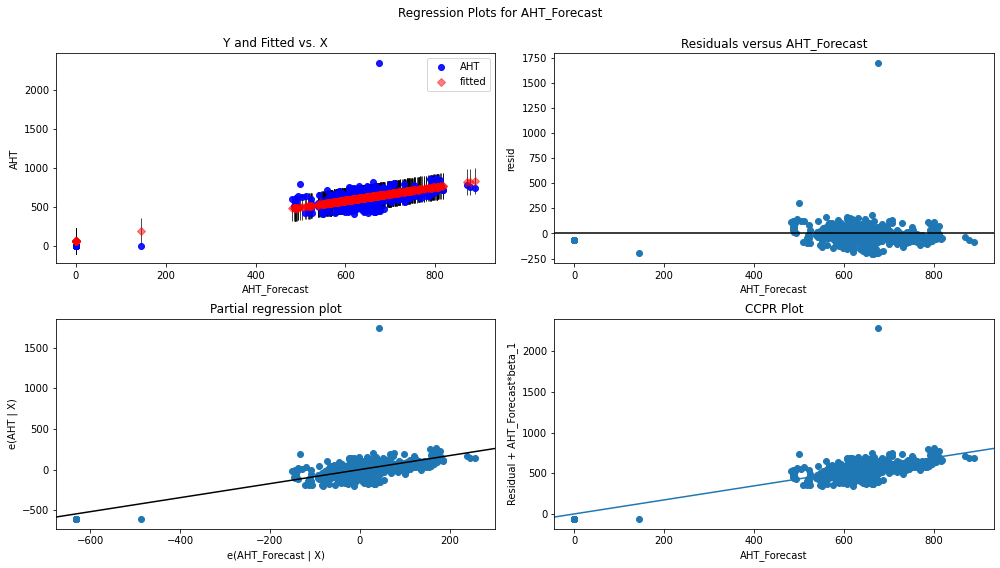

In [ ]:
# fit simple linear regression model
linear_model = ols('AHT ~ AHT_Forecast',
                   data=volume_n).fit()
  
# display model summary
print(linear_model.summary())
  
# modify figure size
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(linear_model,
                                    'AHT_Forecast',
                                    fig=fig)

Sales Performance Residuals 

                            OLS Regression Results                            
Dep. Variable:           SumofSales_O   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     36.24
Date:                Thu, 07 Jul 2022   Prob (F-statistic):           1.08e-05
Time:                        09:34:56   Log-Likelihood:                -274.94
No. Observations:                  20   AIC:                             553.9
Df Residuals:                      18   BIC:                             555.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      7.583e+05   9.97e+05      0.760

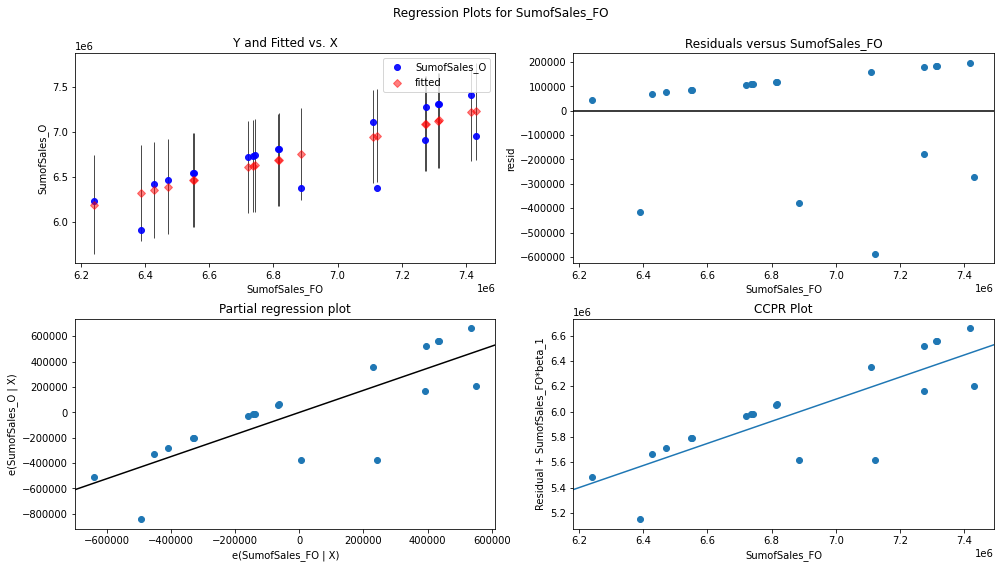

In [ ]:
# fit simple linear regression model
linear_model = ols('SumofSales_O ~ SumofSales_FO',
                   data=online1).fit()
  
# display model summary
print(linear_model.summary())
  
# modify figure size
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(linear_model,
                                    'SumofSales_FO',
                                    fig=fig)

                            OLS Regression Results                            
Dep. Variable:           SumofSales_S   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     67.27
Date:                Thu, 07 Jul 2022   Prob (F-statistic):           1.72e-07
Time:                        09:34:57   Log-Likelihood:                -309.08
No. Observations:                  20   AIC:                             622.2
Df Residuals:                      18   BIC:                             624.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.613e+06   2.56e+06     -0.630

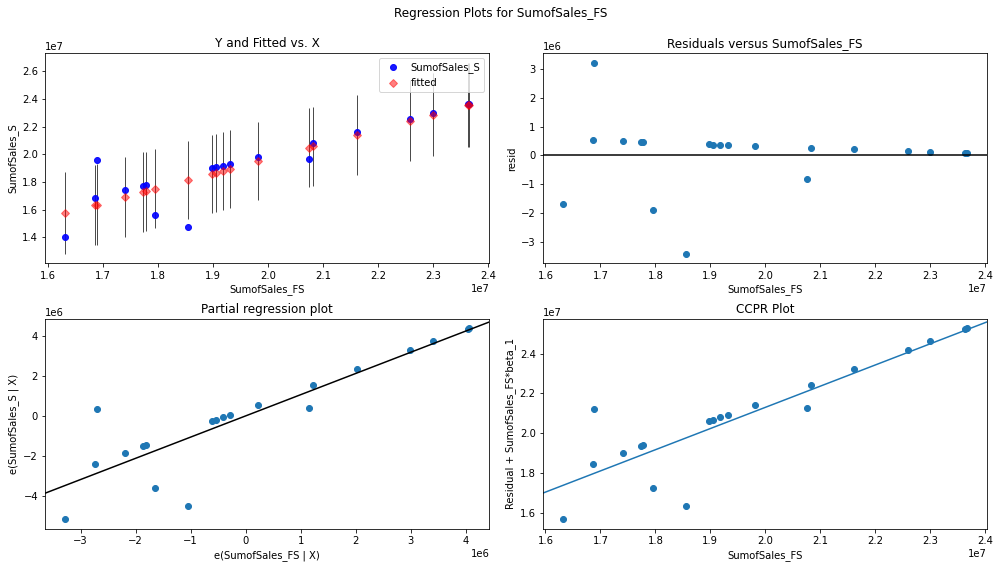

In [ ]:

# fit simple linear regression model
linear_model = ols('SumofSales_S ~ SumofSales_FS',
                   data=store1).fit()
  
# display model summary
print(linear_model.summary())
  
# modify figure size
fig = plt.figure(figsize=(14, 8))
  
# creating regression plots
fig = sm.graphics.plot_regress_exog(linear_model,
                                    'SumofSales_FS',
                                    fig=fig)

# Correlation

In [ ]:
all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 150 entries, 2022-01-15 to 2022-06-13
Freq: D
Columns: 113 entries, Volume_Actual to Total_Forecast
dtypes: bool(3), float64(109), int64(1)
memory usage: 134.6 KB


In [ ]:
pd.set_option('display.max_columns', None)

all.corr()

,Volume_Actual,AHT,Abandon_Count,FB_Likes,FB_Visits,Insta_Likes,Insta_Visits,Abandoned_ratio,Zeeland_Mid_Retail_Rec_%Change,Zeeland_Mid_Park_%Change,Zeeland_Std_Retail_Rec_%Change,Zeeland_Std_Park_%Change,Zeeland_Ave_Retail_Rec_%Change,Zeeland_Ave_Park_%Change,Drenthe_Ave_Retail_Rec_%Change,Drenthe_Ave_Park_%Change,Drenthe_Std_Retail_Rec_%Change,Drenthe_Std_Park_%Change,Drenthe_Mid_Retail_Rec_%Change,Drenthe_Mid_Park_%Change,North Holland_Mid_Retail_Rec_%Change,North Holland_Mid_Park_%Change,North Holland_Ave_Retail_Rec_%Change,North Holland_Ave_Park_%Change,North Holland_Std_Retail_Rec_%Change,North Holland_Std_Park_%Change,Groningen_Mid_Retail_Rec_%Change,Groningen_Mid_Park_%Change,Groningen_Ave_Retail_Rec_%Change,Groningen_Ave_Park_%Change,Groningen_Std_Retail_Rec_%Change,Groningen_Std_Park_%Change,South Holland_Ave_Retail_Rec_%Change,South Holland_Ave_Park_%Change,South Holland_Mid_Retail_Rec_%Change,South Holland_Mid_Park_%Change,South Holland_Std_Retail_Rec_%Change,South Holland_Std_Park_%Change,Gelderland_Mid_Retail_Rec_%Change,Gelderland_Mid_Park_%Change,Gelderland_Std_Retail_Rec_%Change,Gelderland_Std_Park_%Change,Gelderland_Ave_Retail_Rec_%Change,Gelderland_Ave_Park_%Change,Utrecht_Std_Retail_Rec_%Change,Utrecht_Std_Park_%Change,Utrecht_Mid_Retail_Rec_%Change,Utrecht_Mid_Park_%Change,Utrecht_Ave_Retail_Rec_%Change,Utrecht_Ave_Park_%Change,Limburg_Ave_Retail_Rec_%Change,Limburg_Ave_Park_%Change,Limburg_Mid_Retail_Rec_%Change,Limburg_Mid_Park_%Change,Limburg_Std_Retail_Rec_%Change,Limburg_Std_Park_%Change,Friesland_Std_Retail_Rec_%Change,Friesland_Std_Park_%Change,Friesland_Mid_Retail_Rec_%Change,Friesland_Mid_Park_%Change,Friesland_Ave_Retail_Rec_%Change,Friesland_Ave_Park_%Change,Flevoland_Std_Retail_Rec_%Change,Flevoland_Std_Park_%Change,Flevoland_Mid_Retail_Rec_%Change,Flevoland_Mid_Park_%Change,Flevoland_Ave_Retail_Rec_%Change,Flevoland_Ave_Park_%Change,North Brabant_Ave_Retail_Rec_%Change,North Brabant_Ave_Park_%Change,North Brabant_Mid_Retail_Rec_%Change,North Brabant_Mid_Park_%Change,North Brabant_Std_Retail_Rec_%Change,North Brabant_Std_Park_%Change,Overijssel_Std_Retail_Rec_%Change,Overijssel_Std_Park_%Change,Overijssel_Mid_Retail_Rec_%Change,Overijssel_Mid_Park_%Change,Overijssel_Ave_Retail_Rec_%Change,Overijssel_Ave_Park_%Change,DDVEC,FHVEC,FG,FXX,TG,TN,TX,SQ,NG,RH,Holidays,christmas_NY,easter_whit,Mon,Tue,Wed,Thu,Fri,Sat,Sun,stringency_index,new_cases_smoothed,new_deaths_smoothed,Lockdown,SumofSales_O,SumofSales_R,SumofSales_S,# RC (Same day),Sum of Accepted,% RC,Non_Store_Forecast,Store_Forecast,Total_Forecast
Volume_Actual,1.000000,0.539849,0.518246,0.122716,0.238350,0.322460,0.152956,-0.116410,-0.366834,-0.443792,-0.502992,-0.097204,-0.383513,-0.459583,-0.482517,-0.295920,-0.554256,-0.284408,-0.420284,-0.285191,-0.411808,-0.369445,-0.503195,-0.478785,-0.521949,-0.599936,-0.237518,-0.563919,-0.326323,-0.562723,-0.450285,-0.547421,-0.365871,-0.519596,-0.335060,-0.523709,-0.470242,-0.669851,-0.393591,-0.380616,-0.642682,0.019825,-0.429715,-0.409012,-0.480217,-0.404444,-0.333167,-0.373015,-0.374379,-0.435717,-0.292280,-0.382553,-0.271283,-0.397482,-0.566016,-0.430949,-0.590702,-0.445334,-0.530634,-0.541108,-0.564480,-0.564217,-0.450526,-0.371266,-0.415354,-0.438614,-0.464457,-0.412185,-0.260193,-0.519302,-0.264981,-0.361235,-0.483857,-0.362011,-0.693402,-0.318764,-0.491367,-0.417441,-0.554916,-0.428551,0.134714,0.163259,0.164949,0.159750,-0.344462,-0.198359,-0.392079,-0.431818,0.219566,-0.022834,-0.322377,NaN,-0.355759,0.287001,0.199104,0.168642,0.113107,0.131321,-0.253161,-0.634271,0.451425,0.362450,0.218494,NaN,0.236843,0.063617,0.217432,0.835111,0.868184,0.411426,0.103005,0.206662,0.178460
AHT,0.539849,1.000000,0.224257,0.015330,0.002459,-0.018755,0.004213,-0.530252,-0.104776,-0.166350,-0.153228,0.189566,-0.086564,-0.219741,-0.142108,-0.030510,-0.382541,-0.199624,-0.072548,-0.029932,0.016107,-0.044728,-0.060572,-0.125041,-0.208335,-0.284980,0.139375,-0.325841,0.080812,-0.325024,-0.130719,-0.372468,0.0759

In [ ]:
pd.set_option('display.max_rows', None)
correlation = all[all.columns[0:]].corr()['Volume_Actual'][:-1].round(3).abs().sort_values(ascending=False)
correlation

Volume_Actual                           1.000
Sum of Accepted                         0.868
# RC (Same day)                         0.835
Overijssel_Std_Retail_Rec_%Change       0.693
South Holland_Std_Park_%Change          0.670
Gelderland_Std_Retail_Rec_%Change       0.643
Sun                                     0.634
North Holland_Std_Park_%Change          0.600
Friesland_Std_Retail_Rec_%Change        0.591
Limburg_Std_Retail_Rec_%Change          0.566
Groningen_Mid_Park_%Change              0.564
Friesland_Ave_Retail_Rec_%Change        0.564
Friesland_Ave_Park_%Change              0.564
Groningen_Ave_Park_%Change              0.563
Overijssel_Ave_Retail_Rec_%Change       0.555
Drenthe_Std_Retail_Rec_%Change          0.554
Groningen_Std_Park_%Change              0.547
Friesland_Mid_Park_%Change              0.541
AHT                                     0.540
Friesland_Mid_Retail_Rec_%Change        0.531
South Holland_Mid_Park_%Change          0.524
North Holland_Std_Retail_Rec_%Chan

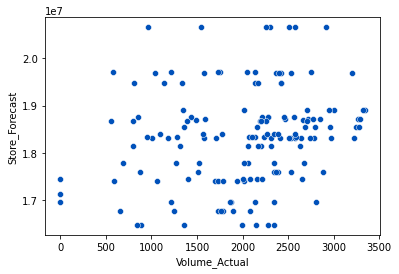

In [ ]:
sns.scatterplot(data=all, x="Volume_Actual", y="Store_Forecast", color = '#0051BA')

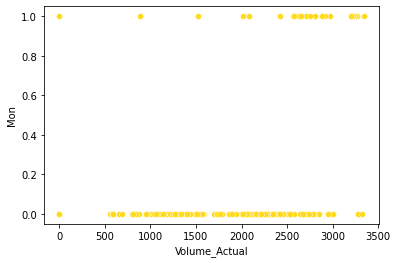

In [ ]:
sns.scatterplot(data=all, x="Volume_Actual", y="Mon", color = '#FFDA1A')

#Stationarity

In [ ]:
stationarity = adfuller(all['Volume_Actual'])
print('Augmented Dickey Fuller p-value: %F' %stationarity[1])

Augmented Dickey Fuller p-value: 0.422872


In [ ]:
Augmented_Dickey_Fuller_Test_func(all['Volume_Actual'],'Volume_Actual')

Results of Dickey-Fuller Test for column: Volume_Actual
Test Statistic                  -1.716031
p-value                          0.422872
No Lags Used                    13.000000
Number of Observations Used    136.000000
Critical Value (1%)             -3.479372
Critical Value (5%)             -2.883037
Critical Value (10%)            -2.578234
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


# Data Distribution Check

QQ plot (quantile-quantile plot)
* Is this data normally distributed? 
 * normal quantiles vs uniform quantiles to find better fit


* Goodness of fit to a distribution: The Chi-squared test can be used to determine whether your data obeys a known theoretical probability distribution such as the Normal or Poisson distribution.

* Goodness of fit of a regression model: The Chi-squared test can be used to measure the goodness-of-fit of your trained regression model on the training, validation, or test data sets.

* Minimum Chi-squared estimation: For data sets that obey parametric distributions such as the Normal, Poisson or Binomial distributions, the the Chi-squared test can be used to find the parameter range over which the observed values will obey the theoretical distribution.

* Test for independence: The Chi-squared test can be used to test whether two categorical random variables such as Age and Income whose values have been measured in an experiment, are independent of each other.


In [ ]:
# QQ plot import
#from scipy.stats import chisquare
from scipy.special import ndtri

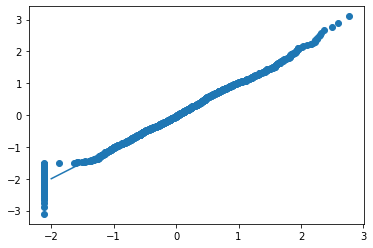

In [ ]:
dist_check = volume_ground.sort_values(by=['Volume_Actual'], ascending = True).reset_index()
#Divide the standard normal distribution that is the theoritical distribution into n+1 = n
dist_check['count'] = dist_check.index+1
n_rows = dist_check.shape[0]
dist_check['percentile_area'] = (dist_check['count'])/n_rows
dist_check['z_theoritical'] = ndtri(dist_check['percentile_area'])
dist_check['z_actual']  = (dist_check['Volume_Actual'] - dist_check['Volume_Actual'].mean())/dist_check['Volume_Actual'].std(ddof = 0)

plt.scatter(dist_check.z_actual, dist_check.z_theoritical)
plt.plot([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])
plt.show()

In [ ]:
dist_check.loc[(dist_check['z_actual'] < -2.3)]

,Date,Volume_Actual,count,percentile_area,z_theoritical,z_actual


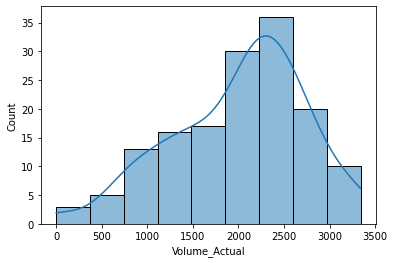

In [ ]:
# Histogram of data distribution
sns.histplot(data = all, x ='Volume_Actual', kde = True)
plt.show()

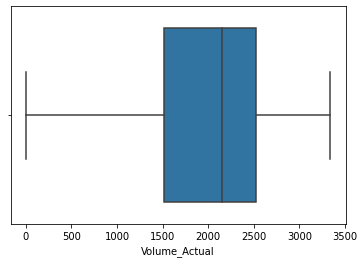

In [ ]:
sns.boxplot(data = all, x ='Volume_Actual')

Actual and theoritical distribution check. Not all points fall on the y=x line. So the data isn't completely distributed.

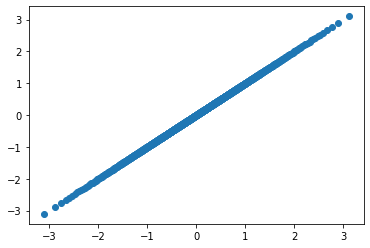

In [ ]:
# This is how it should look like.
plt.scatter(dist_check.z_theoritical, dist_check.z_theoritical)
plt.plot([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

**Hypothesis**\
Note that the mean of volume is 2463 while the variance is 1038276. They are very off from each other. 

There is a over-dispersion and it is not enough to rule out the possibility that volume of call might be Poisson distributed with a theoretical mean rate of 2463.

So two hypotheses were established:\
H0: volume follows a Poisson distribution with a mean of 2463.\
H1: H0 is false. Volume of call is not Poisson distributed.

**Procedure**\
The process to prove (or disprove) H0 using the Chi-squared goodness of fit test. To do so, the following procedure is going to be conducted:



1.   Define the two Hypotheses *completed.
2.   Compute the observed frequencies O_i for each value of the y=volume variable.
3.   Assuming a Poisson distributed y, calculate the expected frequencies E_i for each value of y=volume.
4.   Calculate the test statistic that we have presented above .
5.   Look up the p-value of the test statistic in the Chi-square table. If the p-value is less than 0.05, reject H0 at a 95% confidence level, else accept H0 (i.e. volume are Poisson distributed) at the same confidence level.

In [ ]:
stats_labels = ['Mean Volume_Actual', 'Variance Volume_Actual', 'Minimum Volume_Actual', 'Maximum Volume_Actual']
stats_values = [round(all['Volume_Actual'].mean(), 2), round(all['Volume_Actual'].var(), 2), all['Volume_Actual'].min(), all['Volume_Actual'].max()]
print('Statistical Summary of Dependent Variable (y)')
print(set(zip(stats_labels, stats_values)))

Statistical Summary of Dependent Variable (y)
{('Variance Volume_Actual', 537968.32), ('Maximum Volume_Actual', 3340.0), ('Minimum Volume_Actual', 0.0), ('Mean Volume_Actual', 2005.12)}


In [ ]:
# 2. To calculate the observed frequencies O_i, create a grouped data set, grouping by frequency of volumne.
grouped_all = all.groupby('Volume_Actual').count().sort_values(by='Volume_Actual')
# grouped_all = grouped_all.drop([11,24])
grouped_all['Volume_OBS_FREQ'] = grouped_all['AHT']
grouped_all.at[3, 'Volume_OBS_FREQ'] = 3

grouped_all['Volume_OBS_PROBA'] = grouped_all['Volume_OBS_FREQ']/len(all)

The frequencies for volume >= 5 are very less. The Chi-squared test is not accurate for bins with very small frequencies. To get around this issue, summing up frequencies for all volume >= 5 and associate that number with volume=5. Then, also drop the rows for volume > 5 since volume=5 captures frequencies for all volume >=5.

#**Phase 2: Testing Models**

In this section, Prophet, Prophet+XGB, and Ensembled models are applied for the forecasting. 
1. Apply the organized data into models
2. Run the models
3. Get the assessment scores


# Prep: "Dataset" and "Holidays"

In [ ]:
# bring the date index into column
dataset = all.reset_index()
dataset['Date'] = dataset["index"].dt.strftime('%Y-%m-%d')
# data = data.drop(['index'], axis =1)

In [ ]:
# Data Transformation
dataset.Date = pd.to_datetime(dataset.Date, format = '%Y-%m-%d')
dataset.Date 

0     2022-01-15
1     2022-01-16
2     2022-01-17
3     2022-01-18
4     2022-01-19
5     2022-01-20
6     2022-01-21
7     2022-01-22
8     2022-01-23
9     2022-01-24
10    2022-01-25
11    2022-01-26
12    2022-01-27
13    2022-01-28
14    2022-01-29
15    2022-01-30
16    2022-01-31
17    2022-02-01
18    2022-02-02
19    2022-02-03
20    2022-02-04
21    2022-02-05
22    2022-02-06
23    2022-02-07
24    2022-02-08
25    2022-02-09
26    2022-02-10
27    2022-02-11
28    2022-02-12
29    2022-02-13
30    2022-02-14
31    2022-02-15
32    2022-02-16
33    2022-02-17
34    2022-02-18
35    2022-02-19
36    2022-02-20
37    2022-02-21
38    2022-02-22
39    2022-02-23
40    2022-02-24
41    2022-02-25
42    2022-02-26
43    2022-02-27
44    2022-02-28
45    2022-03-01
46    2022-03-02
47    2022-03-03
48    2022-03-04
49    2022-03-05
50    2022-03-06
51    2022-03-07
52    2022-03-08
53    2022-03-09
54    2022-03-10
55    2022-03-11
56    2022-03-12
57    2022-03-13
58    2022-03-

In [ ]:
# Due to the requirement of FBProphet, rename y column and datastamp variables
dataset = dataset.rename(columns= {'Volume_Actual':'y'})
dataset = dataset.rename(columns= {'Date':'ds'})


In [ ]:
#Holidays
"""""""""""""""""""""""""""""""""""""""
Store holiday dates from the Holidays column
---------------------------------------
In case of Facebook Prophet, holiday data could be simpler as it couls set up
the date range to consider as holidays.
However, it can't specify more details of holiday range. For example, christmas 
holidays can last two weeks while black friday or other national holidays can be less.

If I would like to specify each of the holidays range differently, I would need 
to create each one of these per holiday 
"""""""""""""""""""""""""""""""""""""""
holiday_dates = dataset[dataset.Holidays == 1].ds
holidays = pd.DataFrame({'holiday': 'holi', 
                         'ds':pd.to_datetime(holiday_dates),
                         #'lower_window':0, #3 days prior to the holiday that was counted
                         #'upper_window':0  
                         #1 day after to the holiday that was counted
})                       #upper and lower can be 0 as they are manually specified
holidays.head()

,holiday,ds
90,holi,2022-04-15
91,holi,2022-04-16
92,holi,2022-04-17
93,holi,2022-04-18
98,holi,2022-04-23


In [ ]:
#remove Holidays columns from dataset as the holidays are created seperately.
dataset = dataset.drop(columns = "Holidays")
dataset = dataset.fillna(0)
dataset.head(2)


,index,y,AHT,Abandon_Count,FB_Likes,FB_Visits,Insta_Likes,Insta_Visits,Abandoned_ratio,Zeeland_Mid_Retail_Rec_%Change,Zeeland_Mid_Park_%Change,Zeeland_Std_Retail_Rec_%Change,Zeeland_Std_Park_%Change,Zeeland_Ave_Retail_Rec_%Change,Zeeland_Ave_Park_%Change,Drenthe_Ave_Retail_Rec_%Change,Drenthe_Ave_Park_%Change,Drenthe_Std_Retail_Rec_%Change,Drenthe_Std_Park_%Change,Drenthe_Mid_Retail_Rec_%Change,Drenthe_Mid_Park_%Change,North Holland_Mid_Retail_Rec_%Change,North Holland_Mid_Park_%Change,North Holland_Ave_Retail_Rec_%Change,North Holland_Ave_Park_%Change,North Holland_Std_Retail_Rec_%Change,North Holland_Std_Park_%Change,Groningen_Mid_Retail_Rec_%Change,Groningen_Mid_Park_%Change,Groningen_Ave_Retail_Rec_%Change,Groningen_Ave_Park_%Change,Groningen_Std_Retail_Rec_%Change,Groningen_Std_Park_%Change,South Holland_Ave_Retail_Rec_%Change,South Holland_Ave_Park_%Change,South Holland_Mid_Retail_Rec_%Change,South Holland_Mid_Park_%Change,South Holland_Std_Retail_Rec_%Change,South Holland_Std_Park_%Change,Gelderland_Mid_Retail_Rec_%Change,Gelderland_Mid_Park_%Change,Gelderland_Std_Retail_Rec_%Change,Gelderland_Std_Park_%Change,Gelderland_Ave_Retail_Rec_%Change,Gelderland_Ave_Park_%Change,Utrecht_Std_Retail_Rec_%Change,Utrecht_Std_Park_%Change,Utrecht_Mid_Retail_Rec_%Change,Utrecht_Mid_Park_%Change,Utrecht_Ave_Retail_Rec_%Change,Utrecht_Ave_Park_%Change,Limburg_Ave_Retail_Rec_%Change,Limburg_Ave_Park_%Change,Limburg_Mid_Retail_Rec_%Change,Limburg_Mid_Park_%Change,Limburg_Std_Retail_Rec_%Change,Limburg_Std_Park_%Change,Friesland_Std_Retail_Rec_%Change,Friesland_Std_Park_%Change,Friesland_Mid_Retail_Rec_%Change,Friesland_Mid_Park_%Change,Friesland_Ave_Retail_Rec_%Change,Friesland_Ave_Park_%Change,Flevoland_Std_Retail_Rec_%Change,Flevoland_Std_Park_%Change,Flevoland_Mid_Retail_Rec_%Change,Flevoland_Mid_Park_%Change,Flevoland_Ave_Retail_Rec_%Change,Flevoland_Ave_Park_%Change,North Brabant_Ave_Retail_Rec_%Change,North Brabant_Ave_Park_%Change,North Brabant_Mid_Retail_Rec_%Change,North Brabant_Mid_Park_%Change,North Brabant_Std_Retail_Rec_%Change,North Brabant_Std_Park_%Change,Overijssel_Std_Retail_Rec_%Change,Overijssel_Std_Park_%Change,Overijssel_Mid_Retail_Rec_%Change,Overijssel_Mid_Park_%Change,Overijssel_Ave_Retail_Rec_%Change,Overijssel_Ave_Park_%Change,DDVEC,FHVEC,FG,FXX,TG,TN,TX,SQ,NG,RH,christmas_NY,easter_whit,Mon,Tue,Wed,Thu,Fri,Sat,Sun,stringency_index,new_cases_smoothed,new_deaths_smoothed,Lockdown,SumofSales_O,SumofSales_R,SumofSales_S,# RC (Same day),Sum of Accepted,% RC,Non_Store_Forecast,Store_Forecast,Total_Forecast,ds
0,2022-01-15,2661.0,596.0,1369.0,44.0,1899.0,149.0,2268.0,0.510432,-27.0,-12.0,8.34832,20.868066,-29.777778,-11.857143,-21.50,-2.142857,6.553201,11.495341,-21.0,0.0,-25.0,-25.0,-25.909091,-21.80,16.828851,28.777968,-15.5,23.0,-14.625,23.0,13.710658,1.414214,-21.733333,-3.809524,-21.0,-2.0,11.846365,22.870547,-22.0,0.0,10.499206,23.853721,-20.650000,-7.000000,10.984621,25.143588,-23.0,-24.0,-25.523810,-26.2,-24.736842,-15.416667,-23.0,-17.5,12.822905,29.974105,8.207074,28.500000,-24.0,16.5,-23.583333,18.25,14.346063,23.039304,-25.0,-19.0,-18.857143,-17.142857,-23.866667,-13.400000,-24.0,-8.0,13.320524,22.525541,11.068685,9.988327,-21.0,19.0,-19.100000,19.833333,156.0,29.5,34.0,70.0,29.0,11.0,46.5,0.0,8.0,0.0,False,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,58.33,32567.286,10.714,0.0,1.225004e+07,1.903254e+06,3.133212e+06,420,1324.0,0.317221,8860000.0,18700000.0,27560000.0,2022-01-15
1,2022-01-16,1484.0,635.0,672.0,56.0,1663.0,200.0,2071.0,0.454240,-40.0,-23.0,22.08641,13.894843,-38.857143,-21.666667,-29.25,4.625000,6.551081,13.222681,-29.5,11.0,-28.0,-3.0,-26.105263,-7.75,16.616240,35.872924,-35.0,27.0,-30.200,27.0,9.444575,12.727922,-21.103448,14.200000,-23.0,15.5,17.446540,27.895670,-33.0,12.0,9.550947,23.154348,-32.294118,7.133333,14.074208,18.297541,-24.5,4.0,-27.083333,3.0,-43.066667,-9.500000,-42.0,-10.5,11.221578,28.418499,9.724784,27.012343,-27.0,37.5,-27.714286,35.50,3.785939,18.729656,-31.0,-9.5,-32.666667,-10.

In [ ]:
test_set = dataset.iloc[-test_days:, :]
actual_value = test_set['y']

In [ ]:
actual_value

115    1938.0
116    1700.0
117    1729.0
118    1782.0
119    1058.0
120     584.0
121    2083.0
122    1785.0
123    1726.0
124    1767.0
125    1900.0
126    1250.0
127     659.0
128    2424.0
129    2131.0
130    2173.0
131    1138.0
132    2420.0
133    1332.0
134     810.0
135    2654.0
136    2157.0
137    2210.0
138    2082.0
139    2010.0
140    1404.0
141       0.0
142    1527.0
143    2674.0
144    2344.0
145    2062.0
146    2011.0
147    1274.0
148     686.0
149       0.0
Name: y, dtype: float64

# Model 1: Prophet



**Benefit of Prophet Model**\
(+) dynamic holidays; it allows us to further dig and study about holidays\
(+) customizable and intuitive for non-experts; built-in cross validation and hyperparameter tuning\


**Methodological framework**\
y(t) = c(t)+s(t)+h(t)+x(t)+e

where c(t) = trent, s(t) = seasonality, and h(t) = holiday effects, x(t) = external variables/regressors, and e = error

In [ ]:
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 5)

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Seperating the dataset into Training and Testing
"""""""""""""""""""""""""""""""""""""""""""""""""""
prophet_training_set = dataset.iloc[:-test_days, :]
prophet_test_set = dataset.iloc[-test_days:, :]
prophet_test_set

,index,y,AHT,Abandon_Count,FB_Likes,FB_Visits,Insta_Likes,...,# RC (Same day),Sum of Accepted,% RC,Non_Store_Forecast,Store_Forecast,Total_Forecast,ds
115,2022-05-10,1938.0,717.0,164.0,26.0,595.0,90.0,...,724,1837.0,0.394121,8133000.0,17401000.0,25534000.0,2022-05-10
116,2022-05-11,1700.0,732.0,95.0,31.0,608.0,62.0,...,617,1661.0,0.371463,8133000.0,17401000.0,25534000.0,2022-05-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2022-06-12,686.0,496.0,7.0,19.0,463.0,56.0,...,182,683.0,0.266471,8859000.0,17791000.0,26649000.0,2022-06-12
149,2022-06-13,0.0,625.0,116.0,19.0,463.0,56.0,...,793,2307.0,0.343736,8435000.0,17134000.0,25570000.0,2022-06-13


In [ ]:
#check
stats_labels = ['Mean Volume_Actual', 'Variance Volume_Actual', 'Minimum Volume_Actual', 'Maximum Volume_Actual']
stats_values = [round(prophet_training_set['y'].mean(), 2), round(prophet_training_set['y'].var(), 2), prophet_training_set['y'].min(), prophet_training_set['y'].max()]
print('Statistical Summary of Training Dependent Variable (y)')
print(set(zip(stats_labels, stats_values)))

#check
stats_labels = ['Mean Volume_Actual', 'Variance Volume_Actual', 'Minimum Volume_Actual', 'Maximum Volume_Actual']
stats_values = [round(prophet_test_set['y'].mean(), 2), round(prophet_test_set['y'].var(), 2), prophet_test_set['y'].min(), prophet_test_set['y'].max()]
print('Statistical Summary of Test Dependent Variable (y)')
print(set(zip(stats_labels, stats_values)))

Statistical Summary of Training Dependent Variable (y)
{('Variance Volume_Actual', 509167.81), ('Minimum Volume_Actual', 0.0), ('Maximum Volume_Actual', 3340.0), ('Mean Volume_Actual', 2115.51)}
Statistical Summary of Test Dependent Variable (y)
{('Mean Volume_Actual', 1642.4), ('Minimum Volume_Actual', 0.0), ('Variance Volume_Actual', 473702.48), ('Maximum Volume_Actual', 2674.0)}


**Facebook Prophet Component Descriptions**


*   **Growth** : Linear / Logistic ; how does the trend shape like?
*   **Holidays**: use the one prepared already above
*   **Seasonality**: yearly, weekly, daily
*   **Seasonality_mode**: multiplicative or additive
*   **Seasonality_Prior_scale**: strength of the seasonality (continous number). higher number means stronger seasonality
*   **Holiday_Prior_scale**: strength of the holiday (continous number)
*   **Changepoint_prior_scale**: flexibility of the automatic changepoint selection: how to detect the changes in trend and whether it should detect changes in trend easily or more robust




In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Facebook Prophet Model
"""""""""""""""""""""""""""""""""""""""""""""""""""
m = Prophet(growth = 'linear',
            yearly_seasonality=True, #Jan to Feb etc
            weekly_seasonality=True, #monday to sunday seasonality
            daily_seasonality= True, #if data is daily, then True
            holidays = holidays, #it was already defined earlier
            seasonality_mode ='additive', #use additive seasonality during the pandemic so that it’s not biased by 2020’s abnormal baseline, especially when COVID greatly impacts your time series data.
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05 #this is more to leave it to the model and reflect how easy it is to have a break of trends
            )


m.add_regressor('AHT')
m.add_regressor('Abandon_Count')

m.add_regressor('FB_Likes')
m.add_regressor('FB_Visits')
m.add_regressor('Insta_Likes')
m.add_regressor('Insta_Visits')
m.add_regressor('Abandoned_ratio')
m.add_regressor('Limburg_Mid_Retail_Rec_%Change')
m.add_regressor('Limburg_Mid_Park_%Change')
m.add_regressor('Limburg_Std_Retail_Rec_%Change')
m.add_regressor('Limburg_Std_Park_%Change')
m.add_regressor('Limburg_Ave_Retail_Rec_%Change')
m.add_regressor('Limburg_Ave_Park_%Change')
m.add_regressor('Groningen_Ave_Retail_Rec_%Change')
m.add_regressor('Groningen_Ave_Park_%Change')
m.add_regressor('Groningen_Mid_Retail_Rec_%Change')
m.add_regressor('Groningen_Mid_Park_%Change')
m.add_regressor('Groningen_Std_Retail_Rec_%Change')
m.add_regressor('Groningen_Std_Park_%Change')
m.add_regressor('Gelderland_Std_Retail_Rec_%Change')
m.add_regressor('Gelderland_Std_Park_%Change')
m.add_regressor('Gelderland_Mid_Retail_Rec_%Change')
m.add_regressor('Gelderland_Mid_Park_%Change')
m.add_regressor('Gelderland_Ave_Retail_Rec_%Change')
m.add_regressor('Gelderland_Ave_Park_%Change')
m.add_regressor('Drenthe_Mid_Retail_Rec_%Change')
m.add_regressor('Drenthe_Mid_Park_%Change')
m.add_regressor('Drenthe_Std_Retail_Rec_%Change')
m.add_regressor('Drenthe_Std_Park_%Change')
m.add_regressor('Drenthe_Ave_Retail_Rec_%Change')
m.add_regressor('Drenthe_Ave_Park_%Change')
m.add_regressor('North Brabant_Std_Retail_Rec_%Change')
m.add_regressor('North Brabant_Std_Park_%Change')
m.add_regressor('North Brabant_Mid_Retail_Rec_%Change')
m.add_regressor('North Brabant_Mid_Park_%Change')
m.add_regressor('North Brabant_Ave_Retail_Rec_%Change')
m.add_regressor('North Brabant_Ave_Park_%Change')
m.add_regressor('Overijssel_Std_Retail_Rec_%Change')
m.add_regressor('Overijssel_Std_Park_%Change')
m.add_regressor('Overijssel_Ave_Retail_Rec_%Change')
m.add_regressor('Overijssel_Ave_Park_%Change')
m.add_regressor('Overijssel_Mid_Retail_Rec_%Change')
m.add_regressor('Overijssel_Mid_Park_%Change')
m.add_regressor('North Holland_Std_Retail_Rec_%Change')
m.add_regressor('North Holland_Std_Park_%Change')
m.add_regressor('North Holland_Ave_Retail_Rec_%Change')
m.add_regressor('North Holland_Ave_Park_%Change')
m.add_regressor('North Holland_Mid_Retail_Rec_%Change')
m.add_regressor('North Holland_Mid_Park_%Change')
m.add_regressor('Utrecht_Mid_Retail_Rec_%Change')
m.add_regressor('Utrecht_Mid_Park_%Change')
m.add_regressor('Utrecht_Std_Retail_Rec_%Change')
m.add_regressor('Utrecht_Std_Park_%Change')
m.add_regressor('Utrecht_Ave_Retail_Rec_%Change')
m.add_regressor('Utrecht_Ave_Park_%Change')
m.add_regressor('Friesland_Ave_Retail_Rec_%Change')
m.add_regressor('Friesland_Ave_Park_%Change')
m.add_regressor('Friesland_Std_Retail_Rec_%Change')
m.add_regressor('Friesland_Std_Park_%Change')
m.add_regressor('Friesland_Mid_Retail_Rec_%Change')
m.add_regressor('Friesland_Mid_Park_%Change')
m.add_regressor('Zeeland_Ave_Retail_Rec_%Change')
m.add_regressor('Zeeland_Ave_Park_%Change')
m.add_regressor('Zeeland_Std_Retail_Rec_%Change')
m.add_regressor('Zeeland_Std_Park_%Change')
m.add_regressor('Zeeland_Mid_Retail_Rec_%Change')
m.add_regressor('Zeeland_Mid_Park_%Change')
m.add_regressor('Flevoland_Mid_Retail_Rec_%Change')
m.add_regressor('Flevoland_Mid_Park_%Change')
m.add_regressor('Flevoland_Ave_Retail_Rec_%Change')
m.add_regressor('Flevoland_Ave_Park_%Change')
m.add_regressor('Flevoland_Std_Retail_Rec_%Change')
m.add_regressor('Flevoland_Std_Park_%Change')
m.add_regressor('South Holland_Ave_Retail_Rec_%Change')
m.add_regressor('South Holland_Ave_Park_%Change')
m.add_regressor('South Holland_Std_Retail_Rec_%Change')
m.add_regressor('South Holland_Std_Park_%Change')
m.add_regressor('South Holland_Mid_Retail_Rec_%Change')
m.add_regressor('South Holland_Mid_Park_%Change')
m.add_regressor('DDVEC')
m.add_regressor('FHVEC')
m.add_regressor('FG')
m.add_regressor('FXX')
m.add_regressor('TG')
m.add_regressor('TN')
m.add_regressor('TX')
m.add_regressor('SQ')
m.add_regressor('NG')
m.add_regressor('RH')
# m.add_regressor('Holidays')
m.add_regressor('christmas_NY')
m.add_regressor('easter_whit')
m.add_regressor('Mon')
m.add_regressor('Tue')
m.add_regressor('Wed')
m.add_regressor('Thu')
m.add_regressor('Fri')
m.add_regressor('Sat')
m.add_regressor('Sun')
m.add_regressor('stringency_index')
m.add_regressor('new_cases_smoothed')
m.add_regressor('new_deaths_smoothed')

m.add_regressor('Lockdown')
m.add_regressor('SumofSales_O')
m.add_regressor('SumofSales_R') 
m.add_regressor('SumofSales_S') 
m.add_regressor('# RC (Same day)')
m.add_regressor('Sum of Accepted')
m.add_regressor('% RC')
m.add_regressor('Non_Store_Forecast')
m.add_regressor('Store_Forecast')
m.add_regressor('Total_Forecast')




m.fit(prophet_training_set)

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Forecasting
"""""""""""""""""""""""""""""""""""""""""""""""""""
# Create Future Dataframe
future = m.make_future_dataframe(periods = len(prophet_test_set),
                                 freq = "D")
future.tail(1)

,ds
149,2022-06-13


In [ ]:
# merge regressors
future = pd.concat([future, dataset.iloc[:, 1:-1]], # do not include "ds" and 'y' columns
                    axis = 1)


In [ ]:
future

,ds,y,AHT,Abandon_Count,FB_Likes,FB_Visits,Insta_Likes,...,SumofSales_S,# RC (Same day),Sum of Accepted,% RC,Non_Store_Forecast,Store_Forecast,Total_Forecast
0,2022-01-15,2661.0,596.0,1369.0,44.0,1899.0,149.0,...,3.133212e+06,420,1324.0,0.317221,8860000.0,18700000.0,27560000.0
1,2022-01-16,1484.0,635.0,672.0,56.0,1663.0,200.0,...,3.133212e+06,239,815.0,0.293252,8860000.0,18700000.0,27560000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2022-06-12,686.0,496.0,7.0,19.0,463.0,56.0,...,1.686067e+07,182,683.0,0.266471,8859000.0,17791000.0,26649000.0
149,2022-06-13,0.0,625.0,116.0,19.0,463.0,56.0,...,1.740457e+07,793,2307.0,0.343736,8435000.0,17134000.0,25570000.0


In [ ]:
#Forecasting
forecast = m.predict(future)
forecast.columns.to_list()

['ds',
 'trend',
 'yhat_lower',
 'yhat_upper',
 'trend_lower',
 'trend_upper',
 '# RC (Same day)',
 '# RC (Same day)_lower',
 '# RC (Same day)_upper',
 '% RC',
 '% RC_lower',
 '% RC_upper',
 'AHT',
 'AHT_lower',
 'AHT_upper',
 'Abandon_Count',
 'Abandon_Count_lower',
 'Abandon_Count_upper',
 'Abandoned_ratio',
 'Abandoned_ratio_lower',
 'Abandoned_ratio_upper',
 'DDVEC',
 'DDVEC_lower',
 'DDVEC_upper',
 'Drenthe_Ave_Park_%Change',
 'Drenthe_Ave_Park_%Change_lower',
 'Drenthe_Ave_Park_%Change_upper',
 'Drenthe_Ave_Retail_Rec_%Change',
 'Drenthe_Ave_Retail_Rec_%Change_lower',
 'Drenthe_Ave_Retail_Rec_%Change_upper',
 'Drenthe_Mid_Park_%Change',
 'Drenthe_Mid_Park_%Change_lower',
 'Drenthe_Mid_Park_%Change_upper',
 'Drenthe_Mid_Retail_Rec_%Change',
 'Drenthe_Mid_Retail_Rec_%Change_lower',
 'Drenthe_Mid_Retail_Rec_%Change_upper',
 'Drenthe_Std_Park_%Change',
 'Drenthe_Std_Park_%Change_lower',
 'Drenthe_Std_Park_%Change_upper',
 'Drenthe_Std_Retail_Rec_%Change',
 'Drenthe_Std_Retail_Rec_%Ch

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Prediction
"""""""""""""""""""""""""""""""""""""""""""""""""""
predictions_prophet = forecast.yhat[-test_days:].rename('prophet')
predictions_prophet[:5]

115    1998.552213
116    2069.538450
117    1646.640485
118    2158.236039
119    2030.155330
Name: prophet, dtype: float64

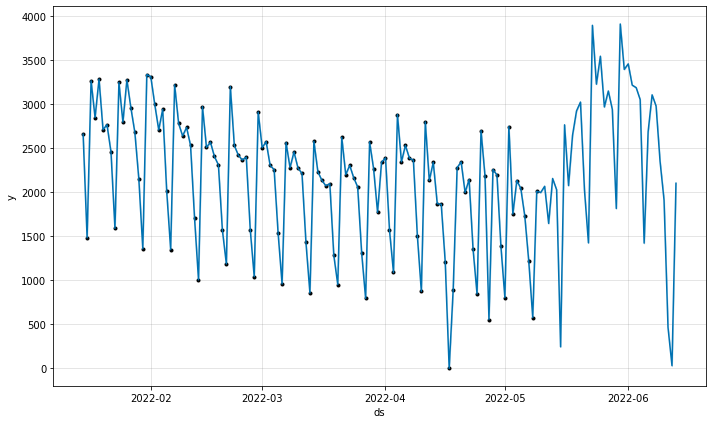

In [ ]:
# Visualization
m.plot(forecast);

Blue line is the actual result, while blue means the result of forecast

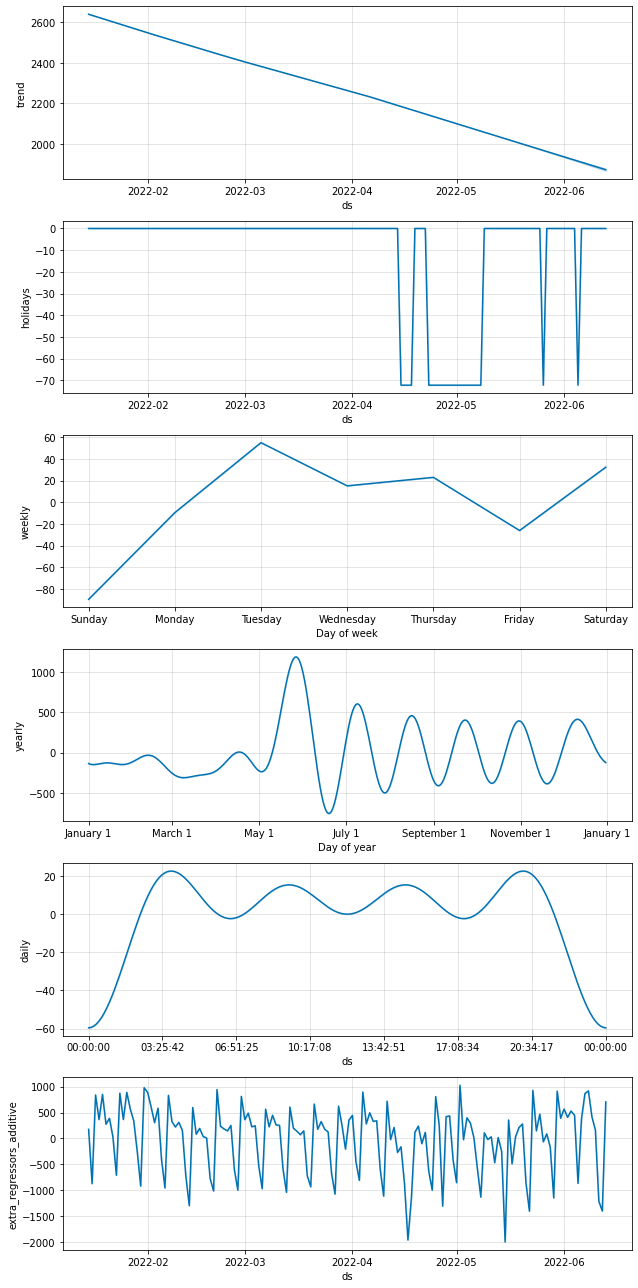

In [ ]:
#plot components
m.plot_components(forecast);

Interpretation of the components:


*   Trend: annual trend. July is the peak season
*   Holiday: the positive part means that that day of holidays are giving more calls to CSC while negative means opposite
*   Week: Monday and Tuesday seems to haave more higher demand of call compared to the weekends
*   Yearly: doesn't seem to have really strong seasonality defined. March has higher demands than Feburary for example. Since the data contains 2.5 years, so it may not be enough to define the seasonality clearly.
*   Regressors: the regressors seem to have more impact on the outcome from 2021 or later.



In [ ]:
predictions_prophet = predictions_prophet.rename('prophet')
predictions_prophet.index = prophet_test_set['ds']
predictions_prophet

ds
2022-05-10    1998.552213
2022-05-11    2069.538450
                 ...     
2022-06-12      29.593365
2022-06-13    2103.858832
Name: prophet, Length: 35, dtype: float64

Text(0.5, 0, 'Date')

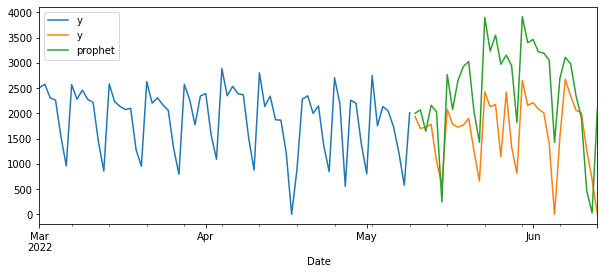

In [ ]:
# Visualization
prophet_training_set.index = prophet_training_set.ds
prophet_test_set.index = prophet_test_set.ds


prophet_training_set.y['2022-03-01':].plot(figsize = (10,4), legend = True)
prophet_test_set.y.plot(legend = True)
predictions_prophet.plot(legend=True)

plt.xlabel('Date')

In [ ]:
actual_value = prophet_test_set['y']

In [ ]:
actual_value

ds
2022-05-10    1938.0
2022-05-11    1700.0
               ...  
2022-06-12     686.0
2022-06-13       0.0
Name: y, Length: 35, dtype: float64

In [ ]:
timeseries_evaluation_metrics_func(actual_value, predictions_prophet)

Evaluation metric results:-
MSE is : 1115310.5142195593
MAE is : 925.8474084088224
RMSE is : 1056.0826266062516
MAPE is : inf
R2 is : -1.4237022338049674



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


This means that the function will return -Inf, Inf, or NaN if actual is zero. Due to the instability at or near zero, smape or mase are often used as alternatives.


MAPE doesn't make sense when y_true can be zero, because division by zero is not defined. You'll have to use a different measurement.



# Model 2: Hybrid

This combined model would meet both seasonality and nonlinearity of the dataset.

**Pros of XGBoost**
* XGBoost gives different weights depending on how difficult it is to predict the outcome over testing multiple trees. Thus, it gives greate weight on the predictor that had wrong outcome. This process continues until the model find the optimal wy for each observations.

* Helps preventing overfitting the model by looking at a fraction of the full dataset per tree. Thus, any dataset comes in the future won't be too must or less influenced.

* Weights are also distributed on different predictors per trees (not only on the data). thus, it creates more and more optimized model that sees what is important and slightly ignores predictions that are not as important.

* Treats NA values as information unlike other models

* non-linear relationship between dependent and independent variables


**Cons of XGBoost**
* complex programming
* can need intense optimization


In [ ]:
# Spliting trainig and test set
FBXGB_training_set = dataset.iloc[:-test_days, :]
FBXGB_test_set = dataset.iloc[-test_days:, :]
FBXGB_training_set

,index,y,AHT,Abandon_Count,FB_Likes,FB_Visits,Insta_Likes,...,# RC (Same day),Sum of Accepted,% RC,Non_Store_Forecast,Store_Forecast,Total_Forecast,ds
0,2022-01-15,2661.0,596.0,1369.0,44.0,1899.0,149.0,...,420,1324.0,0.317221,8860000.0,18700000.0,27560000.0,2022-01-15
1,2022-01-16,1484.0,635.0,672.0,56.0,1663.0,200.0,...,239,815.0,0.293252,8860000.0,18700000.0,27560000.0,2022-01-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,2022-05-08,576.0,510.0,41.0,33.0,793.0,61.0,...,163,543.0,0.300184,9223000.0,19712000.0,28935000.0,2022-05-08
114,2022-05-09,2012.0,664.0,126.0,28.0,552.0,73.0,...,731,2092.0,0.349426,8133000.0,17401000.0,25534000.0,2022-05-09


**XGBoost Preparation**

In [ ]:
# forecast is coming from the prophet model. The previous part may be not necessary
prophet_variables = forecast.loc[:, ['trend', 
                                     'weekly',
                                     'holi',
                                     'yearly',
                                     'daily'#choose variables from "forecast" dataframe
]]

In [ ]:
dataset1 =dataset [[

'y', 'ds',
'AHT', 'Abandon_Count',
 'FB_Likes', 'FB_Visits', 'Insta_Likes', 'Insta_Visits', 'Abandoned_ratio',
 'Gelderland_Mid_Retail_Rec_%Change', 'Gelderland_Mid_Park_%Change',
 'Gelderland_Std_Retail_Rec_%Change', 'Gelderland_Std_Park_%Change',
 'Gelderland_Ave_Retail_Rec_%Change', 'Gelderland_Ave_Park_%Change', 
 'Limburg_Std_Retail_Rec_%Change', 'Limburg_Std_Park_%Change',
 'Limburg_Mid_Retail_Rec_%Change', 'Limburg_Mid_Park_%Change',
 'Limburg_Ave_Retail_Rec_%Change', 'Limburg_Ave_Park_%Change',
 'North Brabant_Ave_Retail_Rec_%Change', 'North Brabant_Ave_Park_%Change',
 'North Brabant_Mid_Retail_Rec_%Change', 'North Brabant_Mid_Park_%Change',
 'North Brabant_Std_Retail_Rec_%Change', 'North Brabant_Std_Park_%Change',
 'Zeeland_Mid_Retail_Rec_%Change', 'Zeeland_Mid_Park_%Change',
 'Zeeland_Ave_Retail_Rec_%Change', 'Zeeland_Ave_Park_%Change',
 'Zeeland_Std_Retail_Rec_%Change', 'Zeeland_Std_Park_%Change',
 'Overijssel_Ave_Retail_Rec_%Change', 'Overijssel_Ave_Park_%Change',
 'Overijssel_Mid_Retail_Rec_%Change', 'Overijssel_Mid_Park_%Change',
 'Overijssel_Std_Retail_Rec_%Change', 'Overijssel_Std_Park_%Change',
 'North Holland_Mid_Retail_Rec_%Change', 'North Holland_Mid_Park_%Change',
 'North Holland_Ave_Retail_Rec_%Change', 'North Holland_Ave_Park_%Change',
 'North Holland_Std_Retail_Rec_%Change', 'North Holland_Std_Park_%Change',
 'Utrecht_Mid_Retail_Rec_%Change', 'Utrecht_Mid_Park_%Change',
 'Utrecht_Ave_Retail_Rec_%Change', 'Utrecht_Ave_Park_%Change',
 'Utrecht_Std_Retail_Rec_%Change', 'Utrecht_Std_Park_%Change',
 'Flevoland_Ave_Retail_Rec_%Change', 'Flevoland_Ave_Park_%Change',
 'Flevoland_Mid_Retail_Rec_%Change', 'Flevoland_Mid_Park_%Change',
 'Flevoland_Std_Retail_Rec_%Change', 'Flevoland_Std_Park_%Change',
 'South Holland_Mid_Retail_Rec_%Change', 'South Holland_Mid_Park_%Change',
 'South Holland_Std_Retail_Rec_%Change', 'South Holland_Std_Park_%Change',
 'South Holland_Ave_Retail_Rec_%Change', 'South Holland_Ave_Park_%Change',
 'Groningen_Std_Retail_Rec_%Change', 'Groningen_Std_Park_%Change',
 'Groningen_Mid_Retail_Rec_%Change', 'Groningen_Mid_Park_%Change',
 'Groningen_Ave_Retail_Rec_%Change', 'Groningen_Ave_Park_%Change',
 'Friesland_Ave_Retail_Rec_%Change', 'Friesland_Ave_Park_%Change',
 'Friesland_Mid_Retail_Rec_%Change', 'Friesland_Mid_Park_%Change',
 'Friesland_Std_Retail_Rec_%Change', 'Friesland_Std_Park_%Change',
 'Drenthe_Mid_Retail_Rec_%Change', 'Drenthe_Mid_Park_%Change',
 'Drenthe_Ave_Retail_Rec_%Change', 'Drenthe_Ave_Park_%Change',
 'Drenthe_Std_Retail_Rec_%Change', 'Drenthe_Std_Park_%Change',
 'DDVEC', 'FHVEC', 'FG', 'FXX', 'TG', 'TN', 'TX', 'SQ', 'NG', 'RH',
 'christmas_NY', 'easter_whit',
 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun',
 'stringency_index',  'new_cases_smoothed', 'new_deaths_smoothed',

 'Lockdown',
 'SumofSales_O', 'SumofSales_S', 'SumofSales_R',
 '# RC (Same day)', 'Sum of Accepted', '% RC',
 'Non_Store_Forecast', 'Store_Forecast', 'Total_Forecast'
        ]]

In [ ]:
# merge the dataset variables and prphet result
df_xgb = pd.concat([dataset1, prophet_variables], axis = 1) 

In [ ]:
pd.set_option('display.max_rows', None)
df_xgb[df_xgb.columns[0:]].corr()['y'][:-1].round(3).abs().sort_values(ascending=False)

y                                       1.000
Sum of Accepted                         0.868
# RC (Same day)                         0.835
Overijssel_Std_Retail_Rec_%Change       0.693
South Holland_Std_Park_%Change          0.670
Gelderland_Std_Retail_Rec_%Change       0.643
Sun                                     0.634
North Holland_Std_Park_%Change          0.600
Friesland_Std_Retail_Rec_%Change        0.591
Limburg_Std_Retail_Rec_%Change          0.566
Friesland_Ave_Park_%Change              0.564
Friesland_Ave_Retail_Rec_%Change        0.564
Groningen_Mid_Park_%Change              0.564
Groningen_Ave_Park_%Change              0.563
Overijssel_Ave_Retail_Rec_%Change       0.555
Drenthe_Std_Retail_Rec_%Change          0.554
Groningen_Std_Park_%Change              0.547
Friesland_Mid_Park_%Change              0.541
AHT                                     0.540
Friesland_Mid_Retail_Rec_%Change        0.531
South Holland_Mid_Park_%Change          0.524
North Holland_Std_Retail_Rec_%Chan

In [ ]:
# Now you can see the seasonality data from Prophet is with the other features
df_xgb

,y,ds,AHT,Abandon_Count,FB_Likes,FB_Visits,Insta_Likes,...,Store_Forecast,Total_Forecast,trend,weekly,holi,yearly,daily
0,2661.0,2022-01-15,596.0,1369.0,44.0,1899.0,149.0,...,18700000.0,27560000.0,2638.704605,32.295762,0.000000,-126.736932,-59.539967
1,1484.0,2022-01-16,635.0,672.0,56.0,1663.0,200.0,...,18700000.0,27560000.0,2633.337120,-89.600788,0.000000,-127.694582,-59.539967
2,3269.0,2022-01-17,749.0,917.0,44.0,1118.0,143.0,...,18705000.0,27814000.0,2627.969634,-9.622325,0.000000,-129.413165,-59.539967
3,2851.0,2022-01-18,712.0,518.0,31.0,1117.0,158.0,...,18705000.0,27814000.0,2622.602149,54.956364,0.000000,-131.750860,-59.539967
4,3288.0,2022-01-19,679.0,785.0,39.0,949.0,165.0,...,18705000.0,27814000.0,2617.234663,15.111562,0.000000,-134.522311,-59.539967
5,2713.0,2022-01-20,655.0,394.0,30.0,784.0,168.0,...,18705000.0,27814000.0,2611.867634,22.947624,0.000000,-137.509073,-59.539967
6,2770.0,2022-01-21,657.0,444.0,27.0,886.0,155.0,...,18705000.0,27814000.0,2606.500605,-26.088199,0.000000,-140.471081,-59.539967
7,2461.0,2022-01-22,713.0,1202.0,36.0,959.0,160.0,...,18705000.0,27814000.0,2601.133575,32.295762,0.000000,-143.158719,-59.539967
8,1591.0,2022-01-23,597.0,731.0,45.0,988.0,167.0,...,18705000.0,27814000.0,2595.767820,-89.600788,0.000000,-145.324999,-59.539967
9,3250.0,2022-01-24,712.0,1124.0,33.0,896.0,131.0,...,18537000.0,26963000.0,2590.402065,-9.622325,0.000000,-146.737422,-59.539967


In [ ]:
# Create Training and Testing dataset
FBXGBcombined_training_set = df_xgb.iloc[:-test_days, :]
FBXGBcombined_test_set = df_xgb.iloc[-test_days:, :]
FBXGBcombined_training_set

,y,ds,AHT,Abandon_Count,FB_Likes,FB_Visits,Insta_Likes,...,Store_Forecast,Total_Forecast,trend,weekly,holi,yearly,daily
0,2661.0,2022-01-15,596.0,1369.0,44.0,1899.0,149.0,...,18700000.0,27560000.0,2638.704605,32.295762,0.000000,-126.736932,-59.539967
1,1484.0,2022-01-16,635.0,672.0,56.0,1663.0,200.0,...,18700000.0,27560000.0,2633.337120,-89.600788,0.000000,-127.694582,-59.539967
2,3269.0,2022-01-17,749.0,917.0,44.0,1118.0,143.0,...,18705000.0,27814000.0,2627.969634,-9.622325,0.000000,-129.413165,-59.539967
3,2851.0,2022-01-18,712.0,518.0,31.0,1117.0,158.0,...,18705000.0,27814000.0,2622.602149,54.956364,0.000000,-131.750860,-59.539967
4,3288.0,2022-01-19,679.0,785.0,39.0,949.0,165.0,...,18705000.0,27814000.0,2617.234663,15.111562,0.000000,-134.522311,-59.539967
5,2713.0,2022-01-20,655.0,394.0,30.0,784.0,168.0,...,18705000.0,27814000.0,2611.867634,22.947624,0.000000,-137.509073,-59.539967
6,2770.0,2022-01-21,657.0,444.0,27.0,886.0,155.0,...,18705000.0,27814000.0,2606.500605,-26.088199,0.000000,-140.471081,-59.539967
7,2461.0,2022-01-22,713.0,1202.0,36.0,959.0,160.0,...,18705000.0,27814000.0,2601.133575,32.295762,0.000000,-143.158719,-59.539967
8,1591.0,2022-01-23,597.0,731.0,45.0,988.0,167.0,...,18705000.0,27814000.0,2595.767820,-89.600788,0.000000,-145.324999,-59.539967
9,3250.0,2022-01-24,712.0,1124.0,33.0,896.0,131.0,...,18537000.0,26963000.0,2590.402065,-9.622325,0.000000,-146.737422,-59.539967


In [ ]:
# isolate X and Y
y_train = FBXGBcombined_training_set.y
y_test = FBXGBcombined_test_set.y

X_train = FBXGBcombined_training_set.drop(columns = {'y', 'ds'})
X_test = FBXGBcombined_test_set.drop(columns = {'y', 'ds'})

In [ ]:
# create XGBoost Matrices
Train = xgb.DMatrix(data = X_train, label = y_train)
Test = xgb.DMatrix(data = X_test, label = y_test)

**Parameters**
* **Minimum Child Weight**: relates to the sum of the weight of each obervation. Low values can mean that maybe not a lot of observations are in the round.
* **ETA**: learning rate; how fast does the model needs to learn? lower learning rate usually
* **Max depth**: how many splits should the tree have? the larger trees, further detailed.
* **Gamma**: how easy and fast should the tree be split? faster? longer?
* **Subsample**: share of observation in each tree? 
* **Colsample by tree**: how much of the tree should be analyzed per round?
* **numbe of rounds**: How many times do we want the analysis to be run?

In [ ]:
# XGBoost Parameters
parameters = {'learning_rate': 0.1, # this is usually changed
              'max_depth': 3, # this is usually changed
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight':1,
              'gamma': 1,
              'random_state': 1502,
              'eval_metric': 'rmse',
              'objective': "reg:squarederror"
}

In [ ]:
# Modeling
model_fbxgb = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 100, # after 100 the rmse may increase more again.
                  evals = [(Test, 'y')],
                  verbose_eval = 15 
                  ) #how much do we want the model to speak with us? Larger the value, more communicate with us
                  

[0]	y-rmse:1590.28
[15]	y-rmse:511.849
[30]	y-rmse:454.053
[45]	y-rmse:456.601
[60]	y-rmse:455.666
[75]	y-rmse:456.081
[90]	y-rmse:455.755
[99]	y-rmse:455.837


In [ ]:
# Forecasting
predictions_xgb = pd.Series(model_fbxgb.predict(Test), name = 'XGBoost')
predictions_xgb.index = FBXGBcombined_test_set.ds

In [ ]:
predictions_xgb[:5]

ds
2022-05-10    1868.002563
2022-05-11    1785.493896
2022-05-12    1755.975586
2022-05-13    1786.138184
2022-05-14    1270.355347
Name: XGBoost, dtype: float32

In [ ]:
# Visualization
FBXGBcombined_training_set.index = FBXGBcombined_training_set.ds
FBXGBcombined_test_set.index = FBXGBcombined_test_set.ds

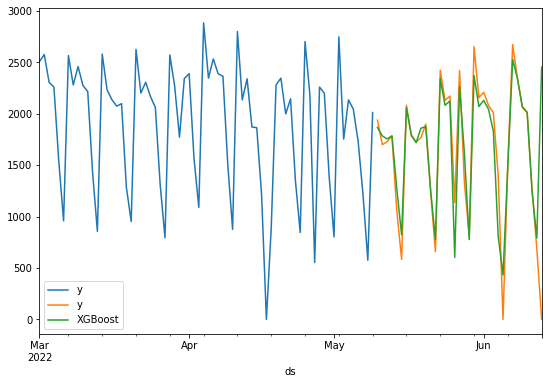

In [ ]:
FBXGBcombined_training_set.y['2022-03-01':].plot(figsize = (9,6), legend = True)
FBXGBcombined_test_set.y.plot(legend = True)
predictions_xgb.plot(legend = True)

In [ ]:
timeseries_evaluation_metrics_func(actual_value, predictions_xgb)

Evaluation metric results:-
MSE is : 207787.07276960558
MAE is : 188.02288818359375
RMSE is : 455.8366733486958
MAPE is : inf
R2 is : 0.5484540080930796



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


P: order of the autoregressive\
D: degree of first differencing involved\
Q: order of the moving average part\

# Model 3: Ensembled Model

In [ ]:
# dfprophet = pd.DataFrame(predictions_prophet)
actual = volume_ground[['Volume_Actual']]
actual.reset_index(inplace=True)
actual = actual.rename(columns = {'index':'Date'})

dfprophet = pd.DataFrame(predictions_prophet)
dfprophet.reset_index(inplace=True)
dfprophet = dfprophet.rename(columns = {'ds':'Date', 'prophet':'Prophet_Prediction'})

dfxgb = pd.DataFrame(predictions_xgb)
dfxgb.reset_index(inplace=True)
dfxgb = dfxgb.rename(columns = {'ds':'Date', 'XGBoost':'prediction'})

fboxfb = dfxgb.rename(columns = {'prediction':'Prophet + XGB'}) 
fbp = dfprophet.rename(columns = {'Prophet_Prediction':'Prophet'}) 

ensembled = pd.merge(fbp , fboxfb, left_on='Date', right_on='Date')
ensembled = pd.merge(ensembled , actual, left_on='Date', right_on='Date')

ensembled = ensembled [['Date',  'Volume_Actual', 'Prophet', 'Prophet + XGB']]
ensembled['Ensembled'] = (ensembled ['Prophet']+ensembled ['Prophet + XGB'])/2
ens = ensembled.Ensembled
ens.index = FBXGBcombined_test_set.ds

#**Phase 3: Future Prediction**

In this section, we repeat the modeling process with future values.\
1. Data: Each data needs to have future values. 
2. Models: Run models using future values.
3. Assessment: Review the statistic scores and compare with the testing phase.
4. Download: Get the forecasting values in CSV file.

# Prep: "Dataset" and "Holidays"

In [ ]:
# bring the date index into column
dataset_future = all_future.reset_index()
dataset_future['Date'] = dataset_future['index'].dt.strftime('%Y-%m-%d')
# data = data.drop(['index'], axis =1)

In [ ]:
# Data Transformation
dataset_future.Date = pd.to_datetime(dataset_future.Date, format = '%Y-%m-%d')
dataset_future.Date 

0     2022-01-15
1     2022-01-16
2     2022-01-17
3     2022-01-18
4     2022-01-19
5     2022-01-20
6     2022-01-21
7     2022-01-22
8     2022-01-23
9     2022-01-24
10    2022-01-25
11    2022-01-26
12    2022-01-27
13    2022-01-28
14    2022-01-29
15    2022-01-30
16    2022-01-31
17    2022-02-01
18    2022-02-02
19    2022-02-03
20    2022-02-04
21    2022-02-05
22    2022-02-06
23    2022-02-07
24    2022-02-08
25    2022-02-09
26    2022-02-10
27    2022-02-11
28    2022-02-12
29    2022-02-13
30    2022-02-14
31    2022-02-15
32    2022-02-16
33    2022-02-17
34    2022-02-18
35    2022-02-19
36    2022-02-20
37    2022-02-21
38    2022-02-22
39    2022-02-23
40    2022-02-24
41    2022-02-25
42    2022-02-26
43    2022-02-27
44    2022-02-28
45    2022-03-01
46    2022-03-02
47    2022-03-03
48    2022-03-04
49    2022-03-05
50    2022-03-06
51    2022-03-07
52    2022-03-08
53    2022-03-09
54    2022-03-10
55    2022-03-11
56    2022-03-12
57    2022-03-13
58    2022-03-

In [ ]:
# Due to the requirement of FBProphet, rename y column and datastamp variables
dataset_future = dataset_future.rename(columns= {'Volume_Actual':'y'})
dataset_future = dataset_future.rename(columns= {'Date':'ds'})


In [ ]:
#Holidays
"""""""""""""""""""""""""""""""""""""""
Store holiday dates from the Holidays column
---------------------------------------
In case of Facebook Prophet, holiday data could be simpler as it couls set up
the date range to consider as holidays.
However, it can't specify more details of holiday range. For example, christmas 
holidays can last two weeks while black friday or other national holidays can be less.

If I would like to specify each of the holidays range differently, I would need 
to create each one of these per holiday >>> check challenge

"""""""""""""""""""""""""""""""""""""""
holiday_dates = dataset_future[dataset_future.Holidays == 1].ds
holidays = pd.DataFrame({'holiday': 'holi', 
                         'ds':pd.to_datetime(holiday_dates),
                         #'lower_window':0, #3 days prior to the holiday that was counted
                         #'upper_window':0  
                         #1 day after to the holiday that was counted
})                       #upper and lower can be 0 as they are manually specified
holidays.head()

,holiday,ds
90,holi,2022-04-15
91,holi,2022-04-16
92,holi,2022-04-17
93,holi,2022-04-18
98,holi,2022-04-23


In [ ]:
#remove Holidays columns from dataset as the holidays are created seperately.
dataset_future = dataset_future.drop(columns = "Holidays")
dataset_future = dataset_future.fillna(0)
dataset_future.head(2)


,index,y,AHT,Abandon_Count,DDVEC,FHVEC,FG,...,Overijssel_Ave_Retail_Rec_%Change,Overijssel_Ave_Park_%Change,FB_Likes,FB_Visits,Insta_Likes,Insta_Visits,ds
0,2022-01-15,2661.0,596.0,1369.0,156.0,29.5,34.0,...,-19.100000,19.833333,44.0,1899.0,149.0,2268.0,2022-01-15
1,2022-01-16,1484.0,635.0,672.0,247.0,44.0,47.0,...,-30.545455,20.125000,56.0,1663.0,200.0,2071.0,2022-01-16


In [ ]:
dataset_future

,index,y,AHT,Abandon_Count,DDVEC,FHVEC,FG,...,Overijssel_Ave_Retail_Rec_%Change,Overijssel_Ave_Park_%Change,FB_Likes,FB_Visits,Insta_Likes,Insta_Visits,ds
0,2022-01-15,2661.0,596.0,1369.0,156.00,29.50,34.0,...,-19.100000,19.833333,44.00000,1899.00000,149.00000,2268.00000,2022-01-15
1,2022-01-16,1484.0,635.0,672.0,247.00,44.00,47.0,...,-30.545455,20.125000,56.00000,1663.00000,200.00000,2071.00000,2022-01-16
2,2022-01-17,3269.0,749.0,917.0,292.00,39.50,42.0,...,-13.923077,24.000000,44.00000,1118.00000,143.00000,1623.00000,2022-01-17
3,2022-01-18,2851.0,712.0,518.0,221.50,12.50,20.0,...,-12.142857,14.500000,31.00000,1117.00000,158.00000,1997.00000,2022-01-18
4,2022-01-19,3288.0,679.0,785.0,253.50,33.00,46.0,...,-18.857143,16.750000,39.00000,949.00000,165.00000,1544.00000,2022-01-19
5,2022-01-20,2713.0,655.0,394.0,331.50,61.00,62.0,...,-24.600000,2.500000,30.00000,784.00000,168.00000,1446.00000,2022-01-20
6,2022-01-21,2770.0,657.0,444.0,296.00,41.00,43.0,...,-27.000000,7.600000,27.00000,886.00000,155.00000,1781.00000,2022-01-21
7,2022-01-22,2461.0,713.0,1202.0,286.00,32.00,33.0,...,-24.200000,17.142857,36.00000,959.00000,160.00000,1948.00000,2022-01-22
8,2022-01-23,1591.0,597.0,731.0,191.50,14.00,17.0,...,-32.000000,30.750000,45.00000,988.00000,167.00000,2176.00000,2022-01-23
9,2022-01-24,3250.0,712.0,1124.0,132.00,13.50,18.0,...,-17.833333,31.666667,33.00000,896.00000,131.00000,1573.00000,2022-01-24


In [ ]:
test_set

,index,y,AHT,Abandon_Count,FB_Likes,FB_Visits,Insta_Likes,...,# RC (Same day),Sum of Accepted,% RC,Non_Store_Forecast,Store_Forecast,Total_Forecast,ds
115,2022-05-10,1938.0,717.0,164.0,26.0,595.0,90.0,...,724,1837.0,0.394121,8133000.0,17401000.0,25534000.0,2022-05-10
116,2022-05-11,1700.0,732.0,95.0,31.0,608.0,62.0,...,617,1661.0,0.371463,8133000.0,17401000.0,25534000.0,2022-05-11
117,2022-05-12,1729.0,649.0,78.0,17.0,579.0,90.0,...,601,1702.0,0.353114,8133000.0,17401000.0,25534000.0,2022-05-12
118,2022-05-13,1782.0,684.0,74.0,24.0,619.0,69.0,...,685,1751.0,0.391205,8133000.0,17401000.0,25534000.0,2022-05-13
119,2022-05-14,1058.0,668.0,45.0,27.0,635.0,72.0,...,349,1030.0,0.338835,8133000.0,17401000.0,25534000.0,2022-05-14
120,2022-05-15,584.0,546.0,8.0,21.0,836.0,64.0,...,174,585.0,0.297436,8133000.0,17401000.0,25534000.0,2022-05-15
121,2022-05-16,2083.0,696.0,106.0,25.0,564.0,76.0,...,759,2024.0,0.375000,8120000.0,16779000.0,24899000.0,2022-05-16
122,2022-05-17,1785.0,688.0,68.0,22.0,522.0,71.0,...,659,1765.0,0.373371,8120000.0,16779000.0,24899000.0,2022-05-17
123,2022-05-18,1726.0,656.0,107.0,15.0,445.0,67.0,...,646,1684.0,0.383610,8120000.0,16779000.0,24899000.0,2022-05-18
124,2022-05-19,1767.0,657.0,147.0,24.0,412.0,55.0,...,675,1803.0,0.374376,8120000.0,16779000.0,24899000.0,2022-05-19


# Model 1: Prophet



**Benefit of Prophet Model**\
(+) dynamic holidays; it allows us to further dig and study about holidays\
(+) customizable and intuitive for non-experts; built-in cross validation and hyperparameter tuning\


**Methodological framework**\
y(t) = c(t)+s(t)+h(t)+x(t)+e

where c(t) = trent, s(t) = seasonality, and h(t) = holiday effects, x(t) = external variables/regressors, and e = error

In [ ]:
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 5)

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Seperating the dataset into Training and Testing
"""""""""""""""""""""""""""""""""""""""""""""""""""
prophet_training_set_future = dataset_future.iloc[:-test_days, :]
prophet_test_set_future = dataset_future.iloc[-test_days:, :]
prophet_test_set_future

,index,y,AHT,Abandon_Count,DDVEC,FHVEC,FG,...,Overijssel_Ave_Retail_Rec_%Change,Overijssel_Ave_Park_%Change,FB_Likes,FB_Visits,Insta_Likes,Insta_Visits,ds
149,2022-06-13,0.0,625.0,116.0,299.5,38.0,41.0,...,9.466667,98.00000,25.37500,556.5000,73.37500,915.12500,2022-06-13
150,2022-06-14,0.0,646.0,103.0,52.5,16.0,25.0,...,12.200000,111.00000,25.31250,597.0625,78.87500,888.31250,2022-06-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2022-07-16,0.0,597.0,134.0,320.0,35.5,39.5,...,5.289773,177.25000,25.65625,556.1250,73.34375,912.03125,2022-07-16
183,2022-07-17,0.0,476.0,105.0,298.5,24.0,28.0,...,19.031250,87.15625,25.65625,556.1250,73.34375,912.03125,2022-07-17


**Facebook Prophet Component Descriptions**


*   **Growth** : Linear / Logistic ; how does the trend shape like?
*   **Holidays**: use the one prepared already above
*   **Seasonality**: yearly, weekly, daily
*   **Seasonality_mode**: multiplicative or additive
*   **Seasonality_Prior_scale**: strength of the seasonality (continous number). higher number means stronger seasonality
*   **Holiday_Prior_scale**: strength of the holiday (continous number)
*   **Changepoint_prior_scale**: flexibility of the automatic changepoint selection: how to detect the changes in trend and whether it should detect changes in trend easily or more robust




In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Facebook Prophet Model
"""""""""""""""""""""""""""""""""""""""""""""""""""
mf = Prophet(growth = 'linear',
            yearly_seasonality=True, #Jan to Feb etc
            weekly_seasonality=True, #monday to sunday seasonality
            daily_seasonality= True, #if data is daily, then True
            holidays = holidays, #it was already defined earlier
            seasonality_mode ='additive', #use additive seasonality during the pandemic so that it’s not biased by 2020’s abnormal baseline, especially when COVID greatly impacts your time series data.
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05 #this is more to leave it to the model and reflect how easy it is to have a break of trends
            )



# Selected Features
mf.add_regressor('Insta_Visits')
mf.add_regressor('North Holland_Std_Retail_Rec_%Change')
mf.add_regressor('North Holland_Std_Park_%Change')
mf.add_regressor('Drenthe_Std_Retail_Rec_%Change')
mf.add_regressor('Drenthe_Std_Park_%Change')
mf.add_regressor('Friesland_Std_Retail_Rec_%Change')
mf.add_regressor('Gelderland_Std_Retail_Rec_%Change')
mf.add_regressor('Gelderland_Std_Park_%Change')
mf.add_regressor('Utrecht_Std_Retail_Rec_%Change')
mf.add_regressor('Utrecht_Std_Park_%Change')
mf.add_regressor('Limburg_Std_Retail_Rec_%Change')
mf.add_regressor('Limburg_Std_Park_%Change')
mf.add_regressor('Overijssel_Std_Retail_Rec_%Change')
mf.add_regressor('North Brabant_Std_Retail_Rec_%Change')
mf.add_regressor('North Brabant_Std_Park_%Change')
mf.add_regressor('Flevoland_Std_Retail_Rec_%Change')
mf.add_regressor('South Holland_Std_Retail_Rec_%Change')
mf.add_regressor('South Holland_Std_Park_%Change')
mf.add_regressor('Zeeland_Std_Retail_Rec_%Change')
mf.add_regressor('Groningen_Std_Retail_Rec_%Change')
mf.add_regressor('stringency_index')
mf.add_regressor('Abandoned_ratio')
mf.add_regressor('# RC (Same day)')
mf.add_regressor('Sum of Accepted')
mf.add_regressor('% RC')
mf.add_regressor('DDVEC')
mf.add_regressor('FHVEC')
mf.add_regressor('FG')
mf.add_regressor('FXX')
mf.add_regressor('TG')
mf.add_regressor('TN')
mf.add_regressor('TX')
mf.add_regressor('NG')


# # no change ; 18
mf.add_regressor('AHT')
mf.add_regressor('Abandon_Count')
# mf.add_regressor('Holidays')
mf.add_regressor('christmas_NY')
mf.add_regressor('easter_whit')
mf.add_regressor('Mon')
mf.add_regressor('Tue')
mf.add_regressor('Wed')
mf.add_regressor('Thu')
mf.add_regressor('Fri')
mf.add_regressor('Sat')
mf.add_regressor('Sun')
mf.add_regressor('Lockdown')
mf.add_regressor('SumofSales_O')
mf.add_regressor('SumofSales_R')
mf.add_regressor('SumofSales_S')
mf.add_regressor('Non_Store_Forecast')
mf.add_regressor('Store_Forecast')
mf.add_regressor('Total_Forecast')


mf.fit(prophet_training_set_future)

In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Forecasting
"""""""""""""""""""""""""""""""""""""""""""""""""""
# Create Future Dataframe
ffuture = mf.make_future_dataframe(periods = len(prophet_test_set_future),
                                 freq = "D")
ffuture.tail(1)

,ds
183,2022-07-17


In [ ]:
# merge regressors
ffuture = pd.concat([ffuture, dataset_future.iloc[:, 1:-1]], # do not include "ds" and 'y' columns
                    axis = 1)


In [ ]:
ffuture

,ds,y,AHT,Abandon_Count,DDVEC,FHVEC,FG,...,Overijssel_Mid_Park_%Change,Overijssel_Ave_Retail_Rec_%Change,Overijssel_Ave_Park_%Change,FB_Likes,FB_Visits,Insta_Likes,Insta_Visits
0,2022-01-15,2661.0,596.0,1369.0,156.0,29.5,34.0,...,19.000,-19.100000,19.833333,44.00000,1899.000,149.00000,2268.00000
1,2022-01-16,1484.0,635.0,672.0,247.0,44.0,47.0,...,24.500,-30.545455,20.125000,56.00000,1663.000,200.00000,2071.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2022-07-16,0.0,597.0,134.0,320.0,35.5,39.5,...,177.250,5.289773,177.250000,25.65625,556.125,73.34375,912.03125
183,2022-07-17,0.0,476.0,105.0,298.5,24.0,28.0,...,94.125,19.031250,87.156250,25.65625,556.125,73.34375,912.03125


In [ ]:
#Forecasting
fforecast = mf.predict(ffuture)
fforecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,# RC (Same day),...,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-15,2686.512156,2651.671909,2708.122665,2686.512156,2686.512156,-181.512707,...,-810.453059,-810.453059,-810.453059,0.0,0.0,0.0,2679.566837
1,2022-01-16,2674.731236,1428.603619,1485.032393,2674.731236,2674.731236,-360.516480,...,-796.319929,-796.319929,-796.319929,0.0,0.0,0.0,1457.303023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2022-07-16,542.384811,-441.191167,-383.384187,542.384786,542.384834,-223.914844,...,-267.435010,-267.435010,-267.435010,0.0,0.0,0.0,-412.052647
183,2022-07-17,530.603891,-1000.369817,-940.789644,530.603866,530.603916,-416.455159,...,-259.635661,-259.635661,-259.635661,0.0,0.0,0.0,-970.469490


In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""
Prediction
"""""""""""""""""""""""""""""""""""""""""""""""""""
predictions_prophet_future = fforecast.yhat[-test_days:].rename('prophet')
predictions_prophet_future[:5]

149    2286.156679
150    1878.383182
151    1828.070605
152    1381.856028
153    1469.039927
Name: prophet, dtype: float64

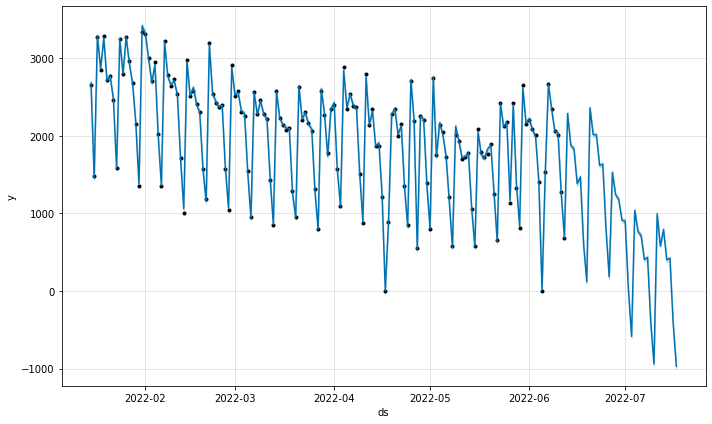

In [ ]:
# Visualization
mf.plot(fforecast);

Blue line is the actual result, while blue means the result of forecast

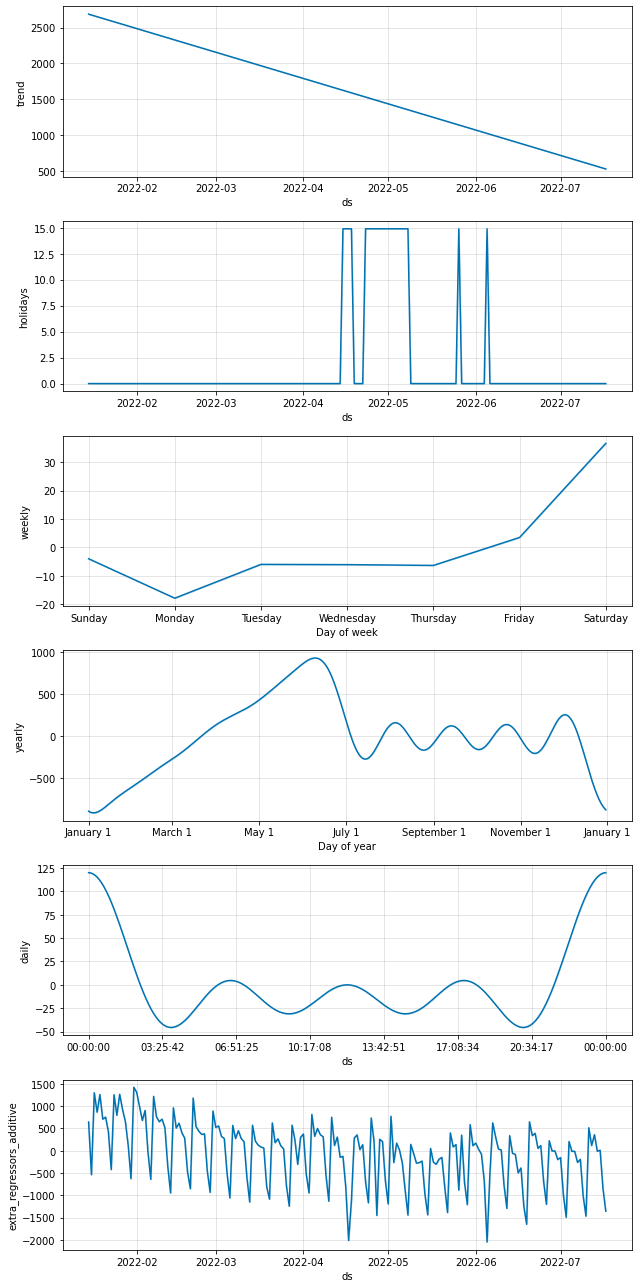

In [ ]:
#plot components
mf.plot_components(fforecast);

Interpretation of the components:


*   Trend: annual trend. July is the peak season
*   Holiday: the positive part means that that day of holidays are giving more calls to CSC while negative means opposite
*   Week: Monday and Tuesday seems to haave more higher demand of call compared to the weekends
*   Yearly: doesn't seem to have really strong seasonality defined. March has higher demands than Feburary for example. Since the data contains 2.5 years, so it may not be enough to define the seasonality clearly.
*   Regressors: the regressors seem to have more impact on the outcome from 2021 or later.



In [ ]:
predictions_prophet_future = predictions_prophet_future.rename('prophet')
predictions_prophet_future.index = prophet_test_set_future['ds']
predictions_prophet_future

ds
2022-06-13    2286.156679
2022-06-14    1878.383182
                 ...     
2022-07-16    -412.052647
2022-07-17    -970.469490
Name: prophet, Length: 35, dtype: float64

Text(0.5, 0, 'Date')

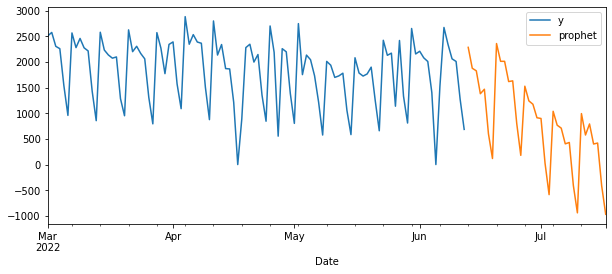

In [ ]:
# Visualization
prophet_training_set_future.index = prophet_training_set_future.ds
prophet_test_set_future.index = prophet_test_set_future.ds


prophet_training_set_future.y['2022-03-01':].plot(figsize = (10,4), legend = True)
# prophet_test_set_future.y.plot(legend = True)
predictions_prophet_future.plot(legend=True)

plt.xlabel('Date')

In [ ]:
'''no metrics can be applied as there are no values to compare with for y and yhat'''
# timeseries_evaluation_metrics_func(actual_value_future, predictions_prophet_future)

'no metrics can be applied as there are no values to compare with for y and yhat'

# Model 2: Hybrid

This combined model would meet both seasonality and nonlinearity of the dataset.

**Pros of XGBoost**
* XGBoost gives different weights depending on how difficult it is to predict the outcome over testing multiple trees. Thus, it gives greate weight on the predictor that had wrong outcome. This process continues until the model find the optimal wy for each observations.

* Helps preventing overfitting the model by looking at a fraction of the full dataset per tree. Thus, any dataset comes in the future won't be too must or less influenced.

* Weights are also distributed on different predictors per trees (not only on the data). thus, it creates more and more optimized model that sees what is important and slightly ignores predictions that are not as important.

* Treats NA values as information unlike other models

* non-linear relationship between dependent and independent variables


**Cons of XGBoost**
* complex programming
* can need intense optimization


In [ ]:
dataset_future.AHT.isnull().sum()

0

In [ ]:
# Spliting trainig and test set
FBXGB_training_set = dataset_future.iloc[:-test_days, :]
FBXGB_test_set = dataset_future.iloc[-test_days:, :]
FBXGB_test_set

,index,y,AHT,Abandon_Count,DDVEC,FHVEC,FG,...,Overijssel_Ave_Retail_Rec_%Change,Overijssel_Ave_Park_%Change,FB_Likes,FB_Visits,Insta_Likes,Insta_Visits,ds
149,2022-06-13,0.0,625.0,116.0,299.5,38.0,41.0,...,9.466667,98.00000,25.37500,556.5000,73.37500,915.12500,2022-06-13
150,2022-06-14,0.0,646.0,103.0,52.5,16.0,25.0,...,12.200000,111.00000,25.31250,597.0625,78.87500,888.31250,2022-06-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,2022-07-16,0.0,597.0,134.0,320.0,35.5,39.5,...,5.289773,177.25000,25.65625,556.1250,73.34375,912.03125,2022-07-16
183,2022-07-17,0.0,476.0,105.0,298.5,24.0,28.0,...,19.031250,87.15625,25.65625,556.1250,73.34375,912.03125,2022-07-17


**XGBoost Preparation**

In [ ]:
prophet_variables = fforecast.loc[:, ['trend', 
                                     'weekly',
                                     'holi',
                                     'yearly',
                                     'daily'#choose variables from "forecast" dataframe
]]

In [ ]:
dataset1 = dataset_future[[

'y', 'ds', 

#selected features
'Insta_Visits',
 'North Holland_Std_Retail_Rec_%Change',
 'North Holland_Std_Park_%Change',
 'Drenthe_Std_Retail_Rec_%Change',
 'Drenthe_Std_Park_%Change',
 'Friesland_Std_Retail_Rec_%Change',
 'Gelderland_Std_Retail_Rec_%Change',
 'Gelderland_Std_Park_%Change',
 'Utrecht_Std_Retail_Rec_%Change',
 'Utrecht_Std_Park_%Change',
 'Limburg_Std_Retail_Rec_%Change',
 'Limburg_Std_Park_%Change',
 'Overijssel_Std_Retail_Rec_%Change',
 'North Brabant_Std_Retail_Rec_%Change',
 'North Brabant_Std_Park_%Change',
 'Flevoland_Std_Retail_Rec_%Change',
 'South Holland_Std_Retail_Rec_%Change',
 'South Holland_Std_Park_%Change',
 'Zeeland_Std_Retail_Rec_%Change',
 'Groningen_Std_Retail_Rec_%Change',
 'stringency_index',
 'Abandoned_ratio',
 '# RC (Same day)',
 'Sum of Accepted',
 '% RC',
 'DDVEC',
 'FHVEC',
 'FG',
 'FXX',
 'TG',
 'TN',
 'TX',
 'NG',


# no change ; 18
'AHT',
'Abandon_Count',
# 'Holidays',
'christmas_NY',
'easter_whit',
'Mon',
'Tue',
'Wed',
'Thu',
'Fri',
'Sat',
'Sun',
'Lockdown',
'SumofSales_O',
'SumofSales_R',
'SumofSales_S',
'Non_Store_Forecast',
'Store_Forecast',
'Total_Forecast',

        ]]

Chooing Only XGB for now with/without Seasonality

In [ ]:
# merge the dataset variables and prphet result
df_xgb = pd.concat([dataset1, prophet_variables], axis = 1) 

In [ ]:
# Now you can see the seasonality data from Prophet is with the other features
df_xgb

,y,ds,Insta_Visits,North Holland_Std_Retail_Rec_%Change,North Holland_Std_Park_%Change,Drenthe_Std_Retail_Rec_%Change,Drenthe_Std_Park_%Change,...,Store_Forecast,Total_Forecast,trend,weekly,holi,yearly,daily
0,2661.0,2022-01-15,2268.00000,16.828851,28.777968,6.553201,11.495341,...,18700000.0,27560000.0,2686.512156,36.642064,0.0,-810.453059,120.052692
1,1484.0,2022-01-16,2071.00000,16.616240,35.872924,6.551081,13.222681,...,18700000.0,27560000.0,2674.731236,-3.973898,0.0,-796.319929,120.052692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,0.0,2022-07-16,912.03125,34.865828,79.682480,17.668514,81.673241,...,18524000.0,27211000.0,542.384811,36.642064,0.0,-267.435010,120.052692
183,0.0,2022-07-17,912.03125,22.309312,55.846664,13.683728,45.874595,...,18524000.0,27211000.0,530.603891,-3.973898,0.0,-259.635661,120.052692


In [ ]:
# Create Training and Testing dataset
FBXGBcombined_training_set = df_xgb.iloc[:-test_days, :]
FBXGBcombined_test_set = df_xgb.iloc[-test_days:, :]
FBXGBcombined_training_set

,y,ds,Insta_Visits,North Holland_Std_Retail_Rec_%Change,North Holland_Std_Park_%Change,Drenthe_Std_Retail_Rec_%Change,Drenthe_Std_Park_%Change,...,Store_Forecast,Total_Forecast,trend,weekly,holi,yearly,daily
0,2661.0,2022-01-15,2268.0,16.828851,28.777968,6.553201,11.495341,...,18700000.0,27560000.0,2686.512156,36.642064,0.0,-810.453059,120.052692
1,1484.0,2022-01-16,2071.0,16.616240,35.872924,6.551081,13.222681,...,18700000.0,27560000.0,2674.731236,-3.973898,0.0,-796.319929,120.052692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,1274.0,2022-06-11,775.5,34.915891,91.115734,19.779057,58.232293,...,17791000.0,26649000.0,954.716989,36.642064,0.0,927.022039,120.052692
148,686.0,2022-06-12,852.0,20.567774,63.492483,42.085627,48.182812,...,17791000.0,26649000.0,942.936070,-3.973898,0.0,922.098142,120.052692


In [ ]:
# isolate X and Y
y_train = FBXGBcombined_training_set.y
y_test = FBXGBcombined_test_set.y

X_train = FBXGBcombined_training_set.drop(columns = {'y', 'ds'})
X_test = FBXGBcombined_test_set.drop(columns = {'y', 'ds'})

In [ ]:
# create XGBoost Matrices
Train = xgb.DMatrix(data = X_train, label = y_train)
Test = xgb.DMatrix(data = X_test, label = y_test)

**Parameters**
* **Minimum Child Weight**: relates to the sum of the weight of each obervation. Low values can mean that maybe not a lot of observations are in the round.
* **ETA**: learning rate; how fast does the model needs to learn? lower learning rate usually
* **Max depth**: how many splits should the tree have? the larger trees, further detailed.
* **Gamma**: how easy and fast should the tree be split? faster? longer?
* **Subsample**: share of observation in each tree? 
* **Colsample by tree**: how much of the tree should be analyzed per round?
* **numbe of rounds**: How many times do we want the analysis to be run?

In [ ]:
# XGBoost Parameters
parameters = {'learning_rate': 0.1, # this is usually changed
              'max_depth': 3, # this is usually changed
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight':1,
              'gamma': 1,
              'random_state': 1502,
              'eval_metric': 'rmse',
              'objective': "reg:squarederror"
}

In [ ]:
# Modeling
model_fbxgb_f = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 100, # after 100 the rmse may increase more again.
                  evals = [(Test, 'y')],
                  verbose_eval = 15 
                  ) #how much do we want the model to speak with us? Larger the value, more communicate with us
                  

[0]	y-rmse:192.254
[15]	y-rmse:1548.42
[30]	y-rmse:1819.07
[45]	y-rmse:1874.45
[60]	y-rmse:1884.82
[75]	y-rmse:1885.91
[90]	y-rmse:1885.85
[99]	y-rmse:1886.57


In [ ]:
# Forecasting
predictions_xgb_future = pd.Series(model_fbxgb_f.predict(Test), name = 'XGBoost')
predictions_xgb_future.index = FBXGBcombined_test_set.ds

In [ ]:
predictions_xgb_future[:5]

ds
2022-06-13    2318.010742
2022-06-14    2035.150635
2022-06-15    1995.581299
2022-06-16    1692.246460
2022-06-17    1673.840088
Name: XGBoost, dtype: float32

In [ ]:
# Visualization
FBXGBcombined_training_set.index = FBXGBcombined_training_set.ds
FBXGBcombined_test_set.index = FBXGBcombined_test_set.ds

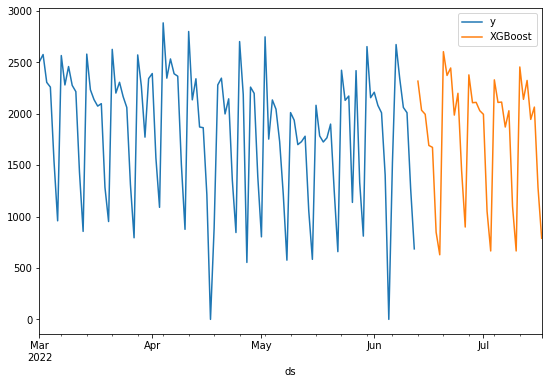

In [ ]:
FBXGBcombined_training_set.y['2022-03-01':].plot(figsize = (9,6), legend = True)
# FBXGBcombined_test_set.y.plot(legend = True)f
predictions_xgb_future.plot(legend = True)

In [ ]:
# timeseries_evaluation_metrics_func(actual_value_future, predictions_xgb_future)

# Model 3: Ensembled Model

In [ ]:
dfprophet = pd.DataFrame(predictions_prophet_future)
dfprophet.reset_index(inplace=True)
dfprophet = dfprophet.rename(columns = {'ds':'Date', 'prophet':'Prophet_Prediction'})

dfxgb = pd.DataFrame(predictions_xgb_future)
dfxgb.reset_index(inplace=True)
dfxgb = dfxgb.rename(columns = {'ds':'Date', 'XGBoost':'prediction'})

fboxfb = dfxgb.rename(columns = {'prediction':'Prophet + XGB'}) 
fbp = dfprophet.rename(columns = {'Prophet_Prediction':'Prophet'}) 

ensembled2 = pd.merge(fbp , fboxfb, left_on='Date', right_on='Date')

ensembled2 = ensembled2 [['Date', # 'Volume_Actual',
                        'Prophet', 'Prophet + XGB']]
ensembled2['Ensembled'] = (ensembled2 ['Prophet'] + ensembled2 ['Prophet + XGB'])/2
ens2 = ensembled2.Ensembled
ens2.index = FBXGBcombined_test_set.ds

In [ ]:
ensembled2

,Date,Prophet,Prophet + XGB,Ensembled
0,2022-06-13,2286.156679,2318.010742,2302.083711
1,2022-06-14,1878.383182,2035.150635,1956.766909
...,...,...,...,...
33,2022-07-16,-412.052647,1284.002808,435.975080
34,2022-07-17,-970.469490,788.820251,-90.824619


# **Phase 4: Prediction Result (IS)**

Assessment Result and Graph for Test Models

In [ ]:
ensembled.loc[ensembled['Volume_Actual']==0, ['Prophet','Prophet + XGB','Ensembled']]=0

ensembled['ratio'] = round((ensembled['Prophet + XGB']-ensembled['Volume_Actual'])/ensembled['Volume_Actual']*100, 2)
ensembled['ratio'] = ensembled['ratio'].replace(np.nan, 0)
# comparison = comparison[['Date', 'Prophet + XGB', 'Volume_Actual', 'ratio']]
ensembled = ensembled.loc[(ensembled['Volume_Actual']>0)]
pd.set_option('display.max_rows', None)
ensembled

,Date,Volume_Actual,Prophet,Prophet + XGB,Ensembled,ratio
0,2022-05-10,1938.0,1998.552213,1868.002563,1933.277388,-3.61
1,2022-05-11,1700.0,2069.538450,1785.493896,1927.516173,5.03
2,2022-05-12,1729.0,1646.640485,1755.975586,1701.308035,1.56
3,2022-05-13,1782.0,2158.236039,1786.138184,1972.187111,0.23
4,2022-05-14,1058.0,2030.155330,1270.355347,1650.255338,20.07
5,2022-05-15,584.0,244.211672,821.944946,533.078309,40.74
6,2022-05-16,2083.0,2768.316241,2059.783691,2414.049966,-1.11
7,2022-05-17,1785.0,2077.344793,1797.892944,1937.618869,0.72
8,2022-05-18,1726.0,2648.351721,1718.730469,2183.541095,-0.42
9,2022-05-19,1767.0,2925.381781,1860.097534,2392.739657,5.27


In [ ]:
feature_cleaning(volume_n)
volume_for = volume_n[['Date','Volume_Forecast']]
volume_for.sort_values(by='Date', ascending=True)

comparisonbb = pd.merge(ensembled, volume_for, left_on = 'Date', right_on = 'Date')

In [ ]:
comparisonbb.head()

,Date,Volume_Actual,Prophet,Prophet + XGB,Ensembled,ratio,Volume_Forecast
0,2022-05-10,1938.0,1998.552213,1868.002563,1933.277388,-3.61,2247
1,2022-05-11,1700.0,2069.538450,1785.493896,1927.516173,5.03,2284
2,2022-05-12,1729.0,1646.640485,1755.975586,1701.308035,1.56,2139
3,2022-05-13,1782.0,2158.236039,1786.138184,1972.187111,0.23,2111
4,2022-05-14,1058.0,2030.155330,1270.355347,1650.255338,20.07,1380


In [ ]:
comparisonbb = comparisonbb.drop(columns=['ratio'])
comparisonbb = comparisonbb.rename(columns = {'Volume_Forecast': 'System Forecast (Baseline)', 'Prophet + XGB': "Hybrid"})

In [ ]:
print('------IS Prophet------')
timeseries_evaluation_metrics_func(ensembled['Volume_Actual'], ensembled['Prophet'])

print('------IS XGB------')
timeseries_evaluation_metrics_func(ensembled['Volume_Actual'], ensembled['Prophet + XGB'])

print('------IS Ensembled------')
timeseries_evaluation_metrics_func(ensembled['Volume_Actual'], ensembled['Ensembled'])


print('------Forecast System--------')
timeseries_evaluation_metrics_func(ensembled['Volume_Actual'], comparisonbb['System Forecast (Baseline)'])


------IS Prophet------
Evaluation metric results:-
MSE is : 987416.9081596396
MAE is : 875.0852985779877
RMSE is : 993.6885367959317
MAPE is : 57.87406799182472
R2 is : -2.137988982397124

------IS XGB------
Evaluation metric results:-
MSE is : 32128.37115020576
MAE is : 111.93428178267045
RMSE is : 179.24388734404798
MAPE is : 8.549805761717744
R2 is : 0.897896750745723

------IS Ensembled------
Evaluation metric results:-
MSE is : 216329.0841151019
MAE is : 407.64893840131197
RMSE is : 465.11190493805026
MAPE is : 26.902685673196093
R2 is : 0.31251097999681

------Forecast System--------
Evaluation metric results:-
MSE is : 68430.0303030303
MAE is : 219.36363636363637
RMSE is : 261.59134217903755
MAPE is : 14.17221330081459
R2 is : 0.7825308849974708



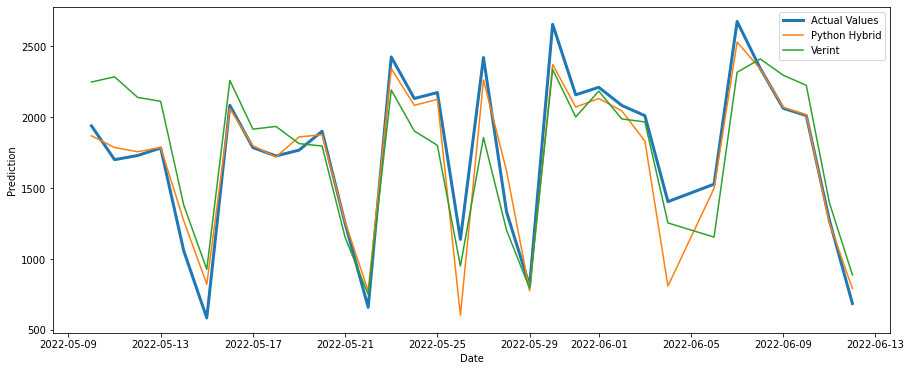

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(x= 'Date', y='Volume_Actual', data= ensembled, palette = colors,  linewidth = 3, label = 'Actual Values')
#sns.lineplot(x= 'Date', y='Prophet', data= ensembled, palette = colors, label = 'Prophet')
sns.lineplot(x= 'Date', y='Prophet + XGB', data= ensembled, palette = colors, label = 'Python Hybrid')
#sns.lineplot(x= 'Date', y='Ensembled', data= ensembled, palette = colors, label = 'Ensembled')
sns.lineplot(x= 'Date', y='System Forecast (Baseline)', data= comparisonbb, palette = colors, label = 'Verint')

plt.xlabel('Date')
plt.ylabel('Prediction')
# plt.title('Multivariate Time Series Forecasting Prediction Comparison',)
plt.legend()
# fig.autofmt_xdate()
plt.show()

[Note] This graph helps to see if it is ready to consider Prophet model.\
The more days are added, Prophet model will perform better, and as a result, Ensembled model would also perform better. If you still see the orange and red lines are way out from the blue line, these models are not ready for use. Then, rely on tehe XGB model.

# **Phase 5: Feature Importance**

Shapely Additive Explanations (ShAP):

This method is considered somewhat better than the traditional sckit-learn methods because many of these methods can be inconsistent, which means that the features that are most important may not always be given the highest feature importance score.

the tree-based models which might give two equally important features different scores based on what level of splitting was done using the features.

The features which split the model first might be given higher importance. This is the motivation for using the latest feature attribution method, Shapley Additive Explanations.

We estimate how important a model is by seeing how well the model performs with and without that feature for every combination of features.

This value is the average marginal contribution of a feature value across all the possible combinations of features.The computation time increases exponentially with the number of features. [Link](https://towardsdatascience.com/a-novel-approach-to-feature-importance-shapley-additive-explanations-d18af30fc21b/)







In [ ]:
!pip install shap 
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 23.5 MB/s 


In [ ]:
explainer = shap.TreeExplainer(model_fbxgb_f)

In [ ]:
shap_values = explainer.shap_values(X_train, check_additivity=False)

SHAP summary plot gives a general overview of each feature a SHAP dependence plot show how the model output varies by feauture value. Note that every dot is a data point, and the vertical dispersion at a single feature value results from interaction effects in the model.

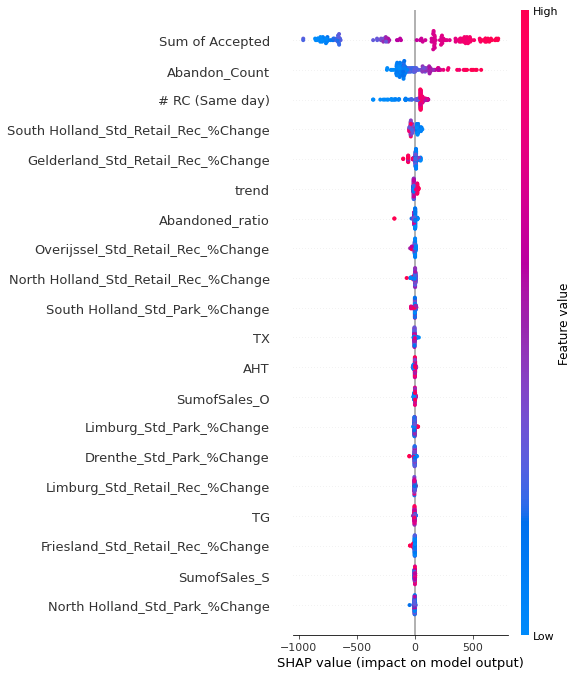

In [ ]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

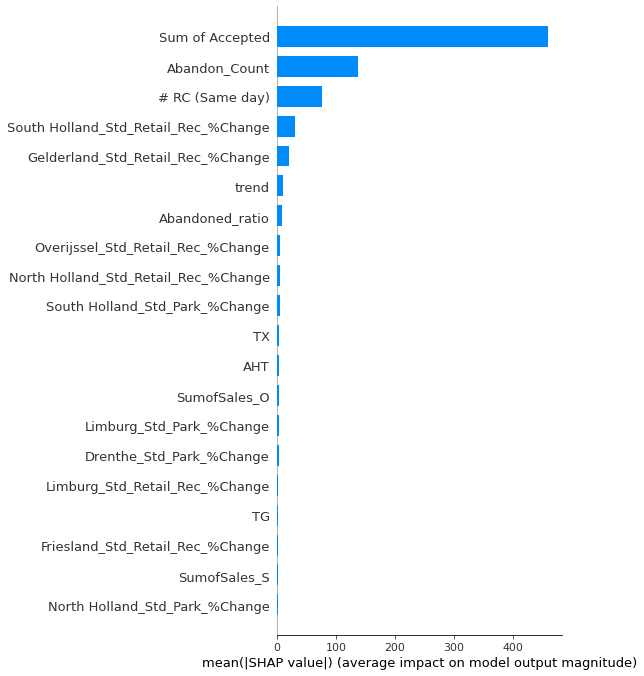

In [ ]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar')

# **Phase 6: Convert the Result to CSV (*)**



In [ ]:
# # XGB model prediction
round(dfxgb).to_csv('# Forecasting_2022-05-25.csv', index = False)

# # Prophet model prediction
# round(dfprophet).to_csv('Prophet_Forecasting_Result.csv', index = False)

# # Ensembled (Prophet+XGB) model prediction
# round(ens).to_csv('Ensembled_Forecasting_Result.csv', index = False)

# # Download predictions of all models
# round(ensembled).to_csv('Forecasting_CV70__XGB.csv', index = False)

# **Phase 7: Statistical Analysis for Forecasters (*)**

# Behind the scene (Don't touch)

Line plot of the forecasted values

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
feature_cleaning(volume_n)
volume_for = volume_n[['Date','Volume_Forecast']]
volume_for.sort_values(by='Date', ascending=True)

# comparison = pd.merge(ensembled2 , actual, left_on='Date', right_on='Date')
comparison = pd.merge(ensembled2, volume_for, left_on = 'Date', right_on = 'Date')
# comparison.loc[comparison['Volume_Actual']==0, ['Prophet','Prophet + XGB','Ensembled']]=0

# comparison = comparison.loc[(comparison['Volume_Actual']>0)]
pd.set_option('display.max_rows', 10)

Correlation feature selection.\
We can add or remove features to include in the correlation plot.

In [ ]:
cols_GM = ['retail_and_recreation_percent_change_from_baseline',
           'parks_percent_change_from_baseline'
           ]
df_GM = GM_region_1.groupby('Date', as_index=False, sort=True)[cols_GM].std()
df_GM.set_index('Date', inplace=True)
df_GM = df_GM.asfreq("D")

df_selectfeatures = [all, df_GM
       ] # do not include CCI as it is difficult to forecast the value
# nan_value = 0

# solution 1 (fast)
df_selectfeatures = pd.concat(df_selectfeatures, join='outer', axis=1)
df_selectfeatures = df_selectfeatures.reindex(new_date_range)

df_selectfeatures = df_selectfeatures.rename(columns = {'TG' : "Ave Temp", 
                                                        'DDVEC': 'Wind Direction', 
                                                        'FHVEC': 'Vector Ave Wind Speed',
                                                        'FG': 'Daily Ave Wind Speed',
                                                        'FXX': 'Highest Wind Gust', 
                                                        'TN': 'Min Temp', 
                                                        'TX':"Max Temp", 
                                                        'SQ':'Sun Duration',
                                                        'NG':'Cloud',
                                                        'RH':'Sun Precipitation',
                                                        'retail_and_recreation_percent_change_from_baseline':'Google Retail Movement Change',
                                                        'parks_percent_change_from_baseline':'Google Park Movement Change'
                                                        })


In [ ]:
# df_selectfeatures.columns.to_list()

In [ ]:
df_selectfeatures = df_selectfeatures[['Volume_Actual', 
 'AHT', 
 'Abandon_Count',#'FB_Likes', 
 'FB_Visits', 
 #'Insta_Likes', 
 'Insta_Visits', 
# 'Abandoned_ratio',

"Ave Temp", 
#'Wind Direction', 'Vector Ave Wind Speed','Highest Wind Gust', 
'Daily Ave Wind Speed',
#'Min Temp', 
"Max Temp", 
'Sun Duration','Cloud',
#'Sun Precipitation',
'stringency_index', 'new_cases_smoothed', 'new_deaths_smoothed',
 'SumofSales_O', 'SumofSales_R', 'SumofSales_S', 
 #'# RC (Same day)', 'Sum of Accepted',
 'Google Retail Movement Change',
 'Google Park Movement Change',
# '% RC',#  'Non_Store_Forecast',#  'Store_Forecast',#  'Total_Forecast'
]]

############# DO NOT Touch###################
scaler = MinMaxScaler()
# transform data
scaled = scaler.fit_transform(df_selectfeatures)
x_scaled = pd.DataFrame(scaled)
df_scaled = pd.DataFrame(x_scaled)
df_scaled.columns = df_selectfeatures.columns
df_scaled.index = df_selectfeatures.index
#df_scaled = df_scaled.reset_index().rename(columns={'index': 'Date'})
df_scaled.head(3)

,Volume_Actual,AHT,Abandon_Count,FB_Visits,Insta_Visits,Ave Temp,Daily Ave Wind Speed,Max Temp,Sun Duration,Cloud,stringency_index,new_cases_smoothed,new_deaths_smoothed,SumofSales_O,SumofSales_R,SumofSales_S,Google Retail Movement Change,Google Park Movement Change
2022-01-15,0.796707,0.788360,1.000000,0.923116,0.218021,0.038806,0.163462,0.038554,0.000000,1.000,1.0,0.254259,0.541316,1.000000,1.000000,0.000000,0.096154,0.069683
2022-01-16,0.444311,0.839947,0.490869,0.802953,0.197781,0.170149,0.288462,0.156627,0.000000,1.000,1.0,0.270547,0.541316,1.000000,1.000000,0.000000,0.195916,0.097679
2022-01-17,0.978743,0.990741,0.669832,0.525458,0.151752,0.244776,0.240385,0.240964,0.122378,0.625,1.0,0.237194,0.503737,0.277923,0.177797,0.821749,0.105134,0.103492


# Prediction Outcome in Graph

This section gives you a line plot graph of the forecasting that forecasters made using Python. You can review the line of the periods and make sure we don't have oddly wrong values. Forecasters can also adjust the values based on the logical decision making.

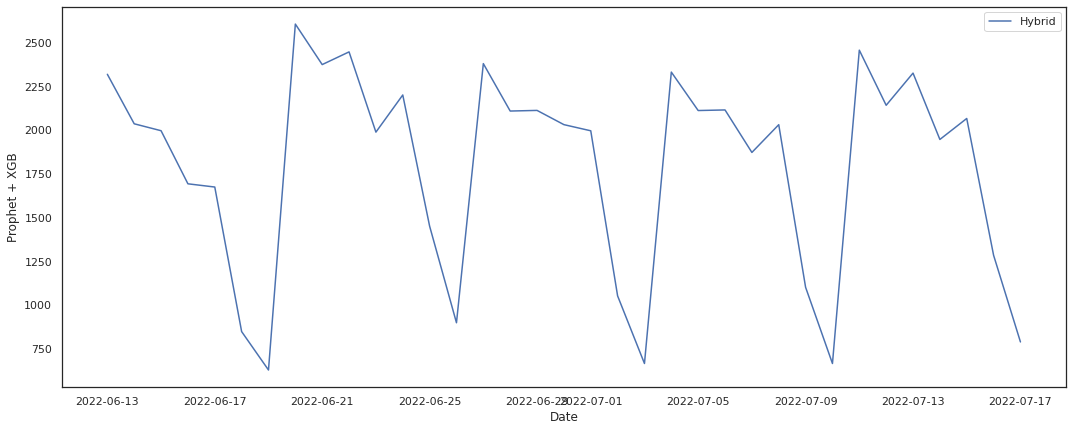

In [ ]:
plt.figure(figsize=(18, 7))
sns.lineplot(x= 'Date', y='Prophet + XGB', data= comparison, palette = colors, label = 'Hybrid')
# sns.lineplot(x= 'Date', y='Volume_Forecast', data= comparison, palette = colors, label = 'Verint Forecast')
# sns.lineplot(x= 'Date', y='Prophet', data= comparison, palette = colors, label = 'Prophet')
# sns.lineplot(x= 'Date', y='Ensembled', data= comparison, palette = colors, label = 'Ensembled')

# Correlation with Volume of Calls

**(1) Adjust dates that you would like to see the correlation** (*only in the red part)\
You can only review the correlation with the available data. So you can't set future values when you enter the date range for the correlation.

In [ ]:
dateofcorr = pd.date_range(start="2022-05-01", end="2022-05-31", freq="D")
dateofcorr = dateofcorr.reindex(dateofcorr)

In [ ]:
# df_scaled.iloc[:,1:10].plot(figsize = (25, 6), legend = True)#.reindex(dateofcorr)
# df_scaled.Volume_Actual.plot(figsize = (25, 6), color = 'blue', linewidth = 3, legend = True)#.reindex(dateofcorr)

# # Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [ ]:
# df_scaled.iloc[:,11:20]['2022-05-01':'2022-05-31'].plot(figsize = (25, 6), legend = True)
# df_scaled.Volume_Actual['2022-05-01': '2022-05-31'].plot(figsize = (25, 6), color = 'blue', linewidth = 3, legend = True)

# # Put the legend out of the figure
# plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

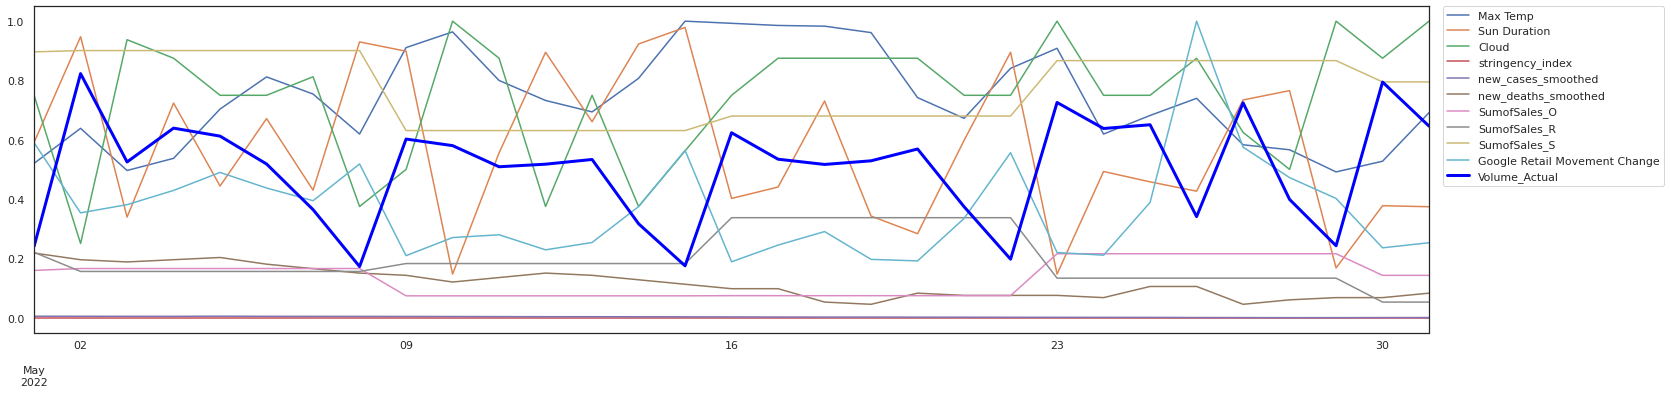

In [ ]:
df_scaled.iloc[:,7:17]['2022-05-01':'2022-05-31'].plot(figsize = (25, 6), legend = True)
df_scaled.Volume_Actual['2022-05-01': '2022-05-31'].plot(figsize = (25, 6), color = 'blue', linewidth = 3, legend = True)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

**(2) Correlation of selected features. The correlation value reflects what you see in the graph.**

In [ ]:
df_selectfeatures.corr()

,Volume_Actual,AHT,Abandon_Count,FB_Visits,Insta_Visits,Ave Temp,Daily Ave Wind Speed,Max Temp,Sun Duration,Cloud,stringency_index,new_cases_smoothed,new_deaths_smoothed,SumofSales_O,SumofSales_R,SumofSales_S,Google Retail Movement Change,Google Park Movement Change
Volume_Actual,1.000000,0.539849,0.518246,0.238350,0.152956,-0.344462,0.164949,-0.392079,-0.431818,0.219566,0.451425,0.362450,0.218494,0.236843,0.063617,0.217432,-0.647254,-0.465976
AHT,0.539849,1.000000,0.224257,0.002459,0.004213,-0.026791,-0.054271,-0.030535,-0.081417,0.142488,-0.001698,0.003513,0.035121,0.032340,-0.069840,-0.015468,-0.372919,-0.182597
Abandon_Count,0.518246,0.224257,1.000000,0.536654,0.265307,-0.514798,0.130520,-0.611081,-0.509689,0.278103,0.698052,0.437058,0.169271,0.648993,0.156909,0.095402,-0.452316,-0.467367
FB_Visits,0.238350,0.002459,0.536654,1.000000,0.345476,-0.585956,0.128668,-0.599366,-0.410185,0.091834,0.575230,0.457573,0.519848,0.654095,0.528973,-0.049709,-0.449632,-0.576925
Insta_Visits,0.152956,0.004213,0.265307,0.345476,1.000000,-0.223929,0.180692,-0.269058,-0.149470,0.000943,0.382404,0.274586,0.112535,0.209110,0.118221,-0.049377,-0.300172,-0.314522
Ave Temp,-0.344462,-0.026791,-0.514798,-0.585956,-0.223929,1.000000,-0.115736,0.946540,0.367778,0.052357,-0.606221,-0.601250,-0.671021,-0.497981,-0.334241,-0.351269,0.545697,0.657605
Daily Ave Wind Speed,0.164949,-0.054271,0.130520,0.128668,0.180692,-0.115736,1.000000,-0.267822,-0.366797,0.270702,0.357422,0.305649,0.208088,0.033628,-0.063976,0.163655,-0.300441,-0.308678
Max Temp,-0.392079,-0.030535,-0.611081,-0.599366,-0.269058,0.946540,-0.267822,1.000000,0.546743,-0.154325,-0.712549,-0.618646,-0.581005,-0.559679,-0.253920,-0.371215,0.567133,0.664409
Sun Duration,-0.431818,-0.081417,-0.509689,-0.410185,-0.149470,0.367778,-0.366797,0.546743,1.000000,-0.697677,-0.563369,-0.363961,-0.238669,-0.464646,-0.138394,-0.214209,0.472576,0.489357
Cloud,0.219566,0.142488,0.278103,0.091834,0.000943,0.052357,0.270702,-0.154325,-0.697677,1.000000,0.261472,0.052094,-0.019275,0.219393,-0.032132,0.090730,-0.151581,-0.130657


**(3) If you want to review some specific date range within the graph, you can change the dates below.**

In [ ]:
df_selectfeatures['2022-05-23':'2022-05-31']

,Volume_Actual,AHT,Abandon_Count,FB_Visits,Insta_Visits,Ave Temp,Daily Ave Wind Speed,Max Temp,Sun Duration,Cloud,stringency_index,new_cases_smoothed,new_deaths_smoothed,SumofSales_O,SumofSales_R,SumofSales_S,Google Retail Movement Change,Google Park Movement Change
2022-05-23,2424.0,683.0,161.0,463.0,749.0,160.5,38.0,227.0,21.0,8.0,19.44,1095.286,1.857,7.276067e+06,1.107576e+06,1.905040e+07,16.155033,53.739636
2022-05-24,2131.0,657.0,99.0,463.0,749.0,130.5,55.0,167.0,70.5,6.0,19.44,1077.857,1.714,7.276067e+06,1.107576e+06,1.905040e+07,15.884403,50.476771
2022-05-25,2173.0,618.0,93.0,463.0,749.0,139.0,67.0,180.0,65.5,6.0,19.44,1058.000,2.429,7.276067e+06,1.107576e+06,1.905040e+07,21.226222,92.551213
2022-05-26,1138.0,561.0,77.0,463.0,749.0,158.5,70.0,192.0,61.0,7.0,19.44,1003.857,2.429,7.276067e+06,1.107576e+06,1.905040e+07,39.586788,127.808377
2022-05-27,2420.0,664.0,403.0,463.0,749.0,136.5,63.0,159.5,105.0,5.0,19.44,984.000,1.286,7.276067e+06,1.107576e+06,1.905040e+07,26.829198,97.076166
2022-05-28,1332.0,618.0,67.0,463.0,749.0,120.5,57.0,156.0,109.5,4.0,19.44,943.000,1.571,7.276067e+06,1.107576e+06,1.905040e+07,23.741247,94.057086
2022-05-29,810.0,595.0,113.0,463.0,749.0,104.0,44.0,140.5,24.0,8.0,19.44,951.857,1.714,7.276067e+06,1.107576e+06,1.905040e+07,21.630766,54.977745
2022-05-30,2654.0,644.0,194.0,463.0,749.0,107.0,19.0,148.0,54.0,7.0,19.44,987.571,1.714,6.813619e+06,1.033513e+06,1.773100e+07,16.630254,56.950887
2022-05-31,2157.0,681.0,104.0,463.0,749.0,126.0,25.0,182.0,53.5,8.0,19.44,995.714,2.000,6.813619e+06,1.033513e+06,1.773100e+07,17.146544,53.214555


The correlation below is the correlation for the entire data forecasters uploaded in the Python.
The values are shown in abusolute so it can be positively or negatively correlated. However, it gives you an idea of which information has more relationship with the volume of calls. 

In [ ]:
correlation

Volume_Actual                        1.000
Sum of Accepted                      0.868
# RC (Same day)                      0.835
Overijssel_Std_Retail_Rec_%Change    0.693
South Holland_Std_Park_%Change       0.670
                                     ...  
SumofSales_R                         0.064
RH                                   0.023
Gelderland_Std_Park_%Change          0.020
christmas_NY                           NaN
Lockdown                               NaN
Name: Volume_Actual, Length: 112, dtype: float64

# Stationarity Test of the Volume of Calls

Stationarity test is a way to see if the volume of calls has a capability to use python prediction (we call "time-series forecasting"). It measures the values based on the Agumented Dickey Fuller p-value. 
Here is the way to see if we can use the python prediction:


*   If the p-value < 0.05, python prediction is not suitable because the data doesn't contain much seasonality.
*   If the p-value > 0.05, we can use the python prediction because the values indicates as suitable for the python prediction.


Note: the larger the p-value, the better the suitability = we predict the forecasting better.



In [ ]:
print('Augmented Dickey Fuller p-value: %F' %stationarity[1])

Augmented Dickey Fuller p-value: 0.422872


# Distribution Check

This graph is called Quantile-Quantile plot (a.k.a Q-Q plot).\
It helps you to see if the volume of calls is normally distributed or not. When the line is streight like this example image, we call it "normally distributed", meaning we can predict with better accuracy.  
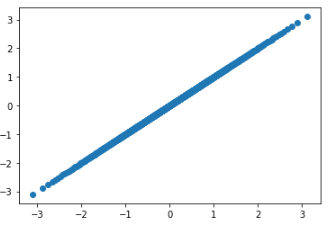


If the line is not streight and more curved, it means we will have more difficult time to predict using the existing data.

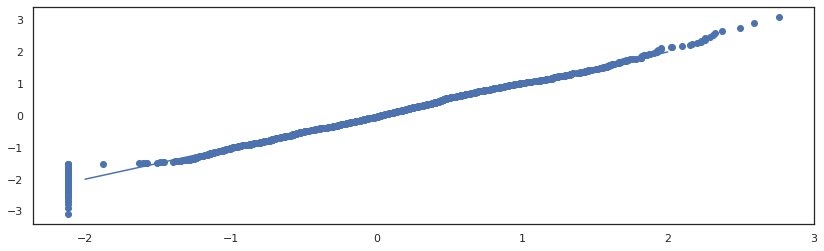

In [ ]:
plt.scatter(dist_check.z_actual, dist_check.z_theoritical)
plt.plot([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])
plt.show()

# Coefficient of Variation Check

Coefficient of Variation(CV) gives you an idea of how much variation the data has shown in percentage.
Highe variance means it is difficult to predict, while the lower variance means we can predict easier.

Normally, we say CV within 0-100% means it is lower variance (0-80% is even better). If the result is below 0% or over 100%, then it is too much variance. Thus, we can't have good predictability of the volume of customers.



In [ ]:
print('CV of the volume of calls is: ',)
print('-----------------------------')
print(df_vnew)

CV of the volume of calls is: 
-----------------------------
               value
Volume_Actual  47.31


In [ ]:
print('CV of each data features is: ',)
print('-------------------------------------------------')
pd.set_option('display.max_rows', None)
print(df_new)

CV of each data features is: 
-------------------------------------------------
                                 level_0    value
0                               FB_Likes    80.74
1                              FB_Visits    81.49
2                            Insta_Likes   144.71
3                           Insta_Visits    65.05
4         Zeeland_Mid_Retail_Rec_%Change -9472.43
5               Zeeland_Mid_Park_%Change   113.21
6         Zeeland_Std_Retail_Rec_%Change    70.83
7               Zeeland_Std_Park_%Change   101.78
8         Zeeland_Ave_Retail_Rec_%Change  7817.12
9               Zeeland_Ave_Park_%Change   119.07
10        Drenthe_Ave_Retail_Rec_%Change  -248.98
11              Drenthe_Ave_Park_%Change   117.85
12        Drenthe_Std_Retail_Rec_%Change    56.61
13              Drenthe_Std_Park_%Change    72.51
14        Drenthe_Mid_Retail_Rec_%Change  -218.56
15              Drenthe_Mid_Park_%Change   118.03
16  North Holland_Mid_Retail_Rec_%Change  -111.42
17        North Holl

# Data Check

These graphs represents the data you uploaded into Python.
Please quickly check them to see if there are no missing data. If you seea streight like with zero values, it is more likely that you forgot to collect the data and uploaded nothing into Python.
So, this is a way to double check if you collected the data right and predicted with 100% necessary data.

In [ ]:
sns.set(rc={'figure.figsize':(14,4)})
sns.set_style("white")

Verint Actual Value
It is normal for this volume data to be empty in ahead since we want to predict the values with this Python Prediction


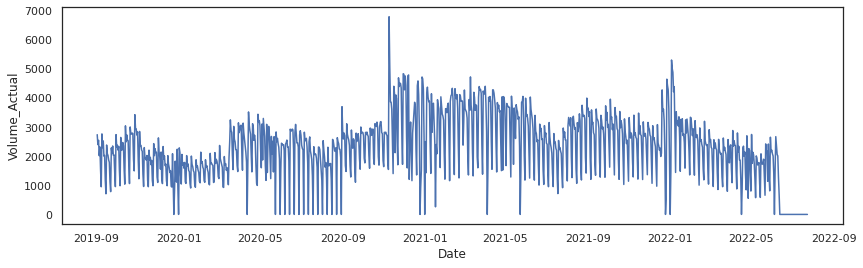

In [ ]:
print('Verint Actual Value')
print('It is normal for this volume data to be empty in ahead since we want to predict the values with this Python Prediction')
sns.lineplot(data = volume_ground['Volume_Actual'], palette = colors)
plt.show()

AHT


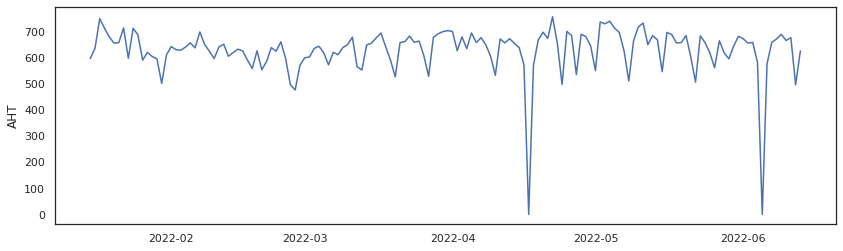

In [ ]:
print('AHT')
sns.lineplot(data = volume_feautures1['AHT']['2021-03-22':], palette = colors)
plt.show()

Instagram Likes


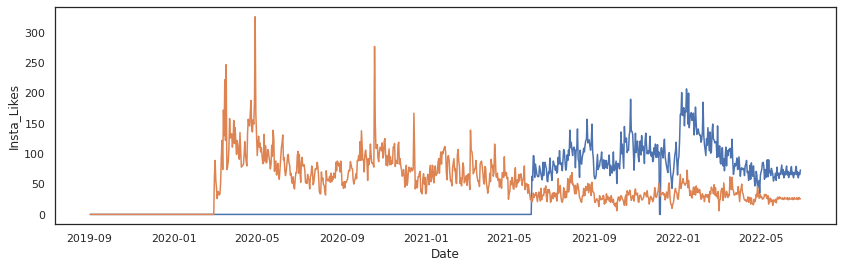

In [ ]:
print('Instagram Likes')
sns.lineplot(data = social['Insta_Likes'], palette = colors)
sns.lineplot(data = social['FB_Likes'], palette = colors)
plt.show()

Facebook Visits


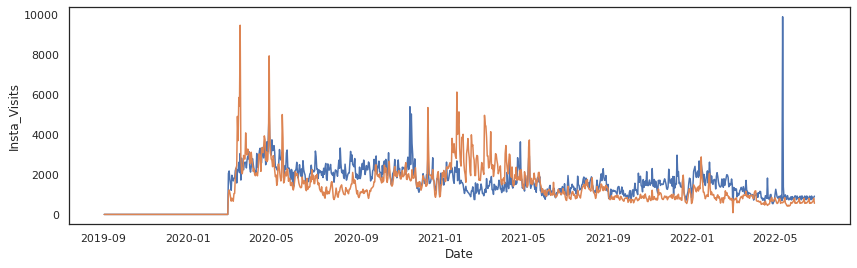

In [ ]:
print('Facebook Visits')
sns.lineplot(data = social['Insta_Visits'], palette = colors)
sns.lineplot(data = social['FB_Visits'], palette = colors)
plt.show()

Abandoned


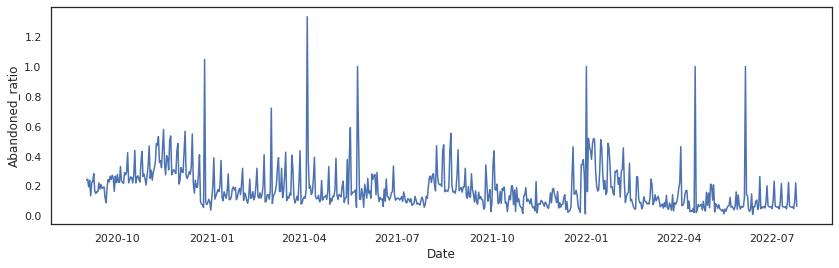

In [ ]:
print('Abandoned')
sns.lineplot(data = Abandoned['Abandoned_ratio'], palette = colors)
plt.show()

Repeated Calls


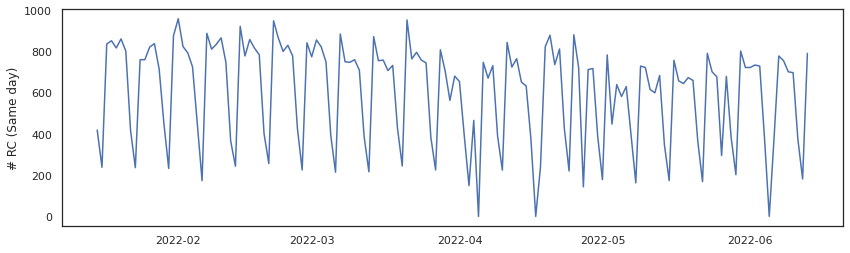

In [ ]:
print('Repeated Calls')
sns.lineplot(data = repeated1['# RC (Same day)'], palette = colors)
plt.show()

Google Community Mobility Report


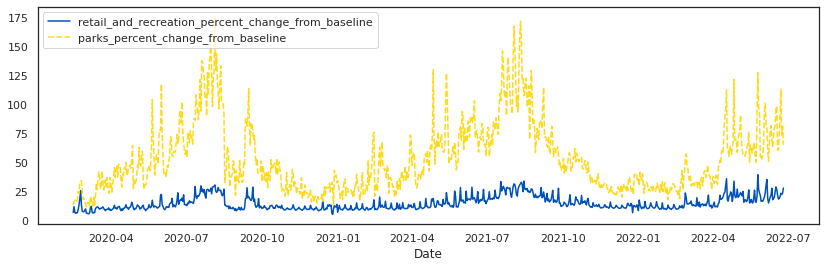

In [ ]:
print('Google Community Mobility Report')
sns.lineplot(data = df_GM, palette = colors)
plt.show()

KMNI Weather


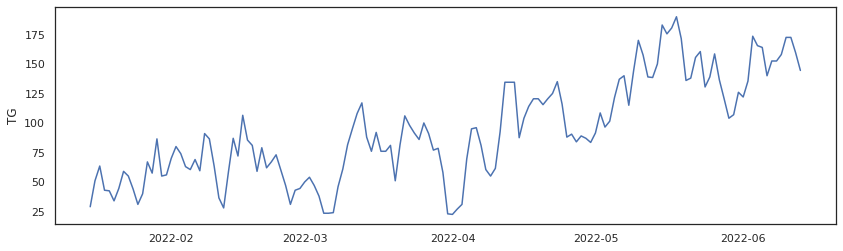

In [ ]:
print('KMNI Weather')
sns.lineplot(data = weather1['TG'], palette = 'g')
plt.show()

Covid Stringency Index


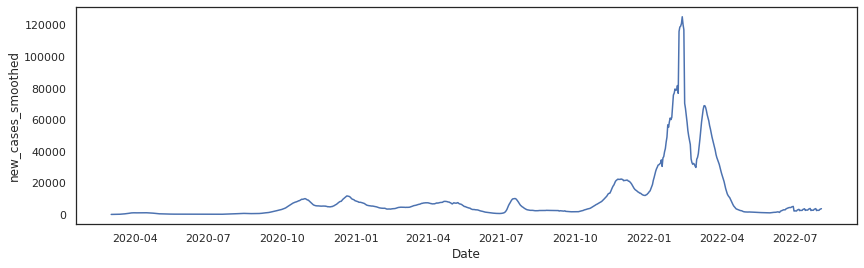

In [ ]:
print('Covid Stringency Index')
sns.lineplot(data = NL_Stringency['new_cases_smoothed'], palette = colors)
plt.show()

Holidays and Lockdown


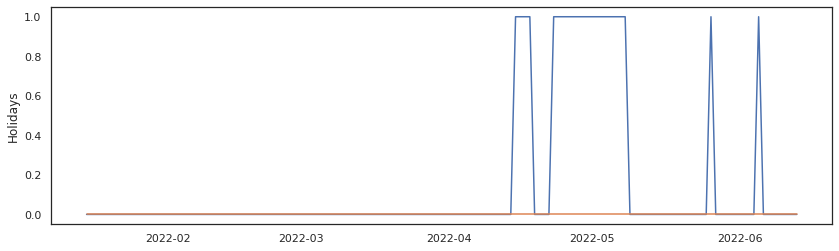

In [ ]:
print('Holidays and Lockdown')
sns.lineplot(data = holi1['Holidays'], palette = colors)
sns.lineplot(data = lockdown1['Lockdown'], palette = colors)
plt.show()

Sales Performance


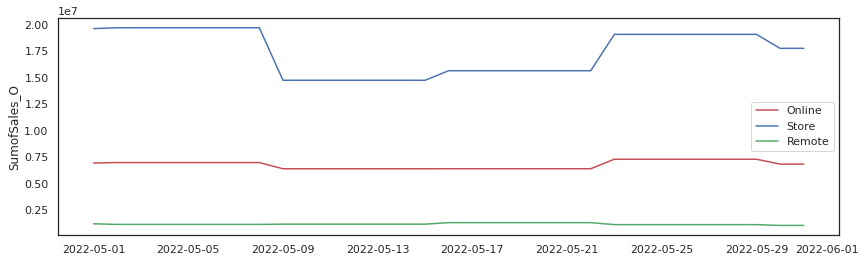

In [ ]:
print('Sales Performance')
sns.lineplot(data = market_sales1['SumofSales_O'], color = 'r', label = 'Online')
sns.lineplot(data = market_sales1['SumofSales_S'], color = 'b', label = 'Store')
sns.lineplot(data = market_sales1['SumofSales_R'], color = 'g', label = 'Remote')
plt.show()

Sales Forecast


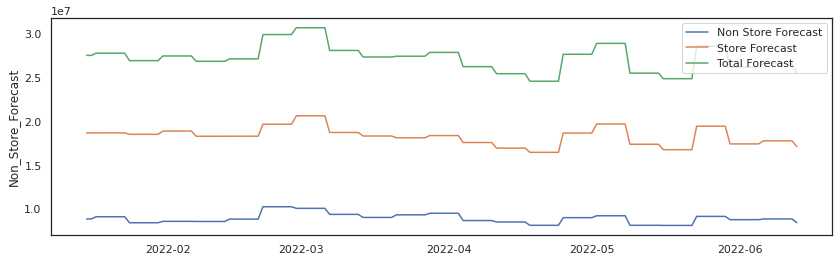

In [ ]:
print('Sales Forecast')
sns.lineplot(data = salesforecast1['Non_Store_Forecast'], palette = colors, label ='Non Store Forecast')
sns.lineplot(data = salesforecast1['Store_Forecast'], palette = colors, label = 'Store Forecast')
sns.lineplot(data = salesforecast1['Total_Forecast'], palette = colors, label = 'Total Forecast')
plt.show()